# Predicting individuals' average credit card debt - A Multivariate Linear Regression Analysis 

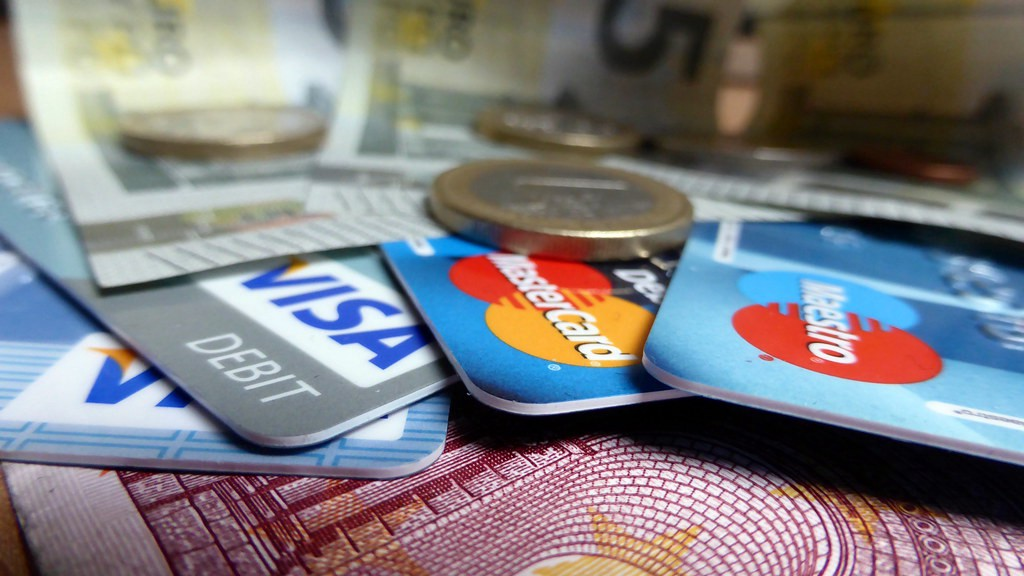

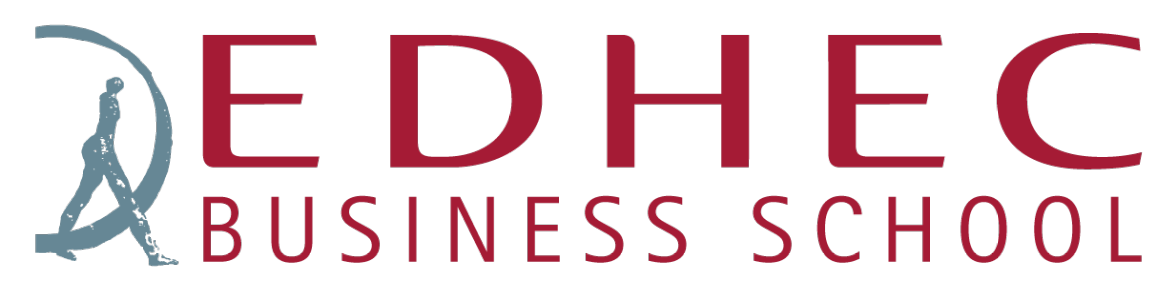

## MSc Data Analytics and Artificial Intelligence 2020/2021 - Python Programming Course


## Charles LIETAR (57488) - Hojun JUNG (61781) - Omar EL HAJJAR (74098)



-------------------------------------------------------------------------------------------------------------------------------

# Introduction 

### [Goal]: Given a dataset containing information regarding credit card owners, the goal is to predict their average amount of debt using Multivariate regression models. 



### [Method]:   To do so, we are given several features describing a credit card owner's profile such as demographics variables  (his education level, age, gender, ethnicity..) or financial information (his credit limit, credit rating, number of credit cards..) 

### Thus, the problem comes down to estimating a linear relationship between our target variable Y (the average amount of debt) and the available feature vector X such as : 

$\mathbf{Y}= \mathbf{X}\boldsymbol{\beta} + \boldsymbol{\epsilon}$  where 

$$
\mathbf{Y}=\left[\begin{array}{r}
                    y_1\\
                    \vdots\\
                    y_n
                  \end{array}\right], \quad
\mathbf{X}=\left[\begin{array}{cccc}
                    1&x_{11}&\ldots&x_{1k}\\
                    \vdots&\vdots&\ddots&\vdots\\
                    1&x_{n1}&\ldots&x_{nk}\end{array}\right],\quad
\boldsymbol{\beta}  =\left[\begin{array}{r}
                      \beta _0\\
                      \beta _1\\
                      \vdots\\
                      \beta _k\\
              \end{array}\right],\quad
\boldsymbol{\epsilon} =\left[\begin{array}{r}
                        \epsilon_1\\
                        \vdots\\
                        \epsilon_n\\
                      \end{array}\right]
$$


$\boldsymbol{\beta}$ being the estimated vector of coefficients and $\boldsymbol{\epsilon}$ being the vector containing the error terms


### The purpose of this notebook is to present our reasoning strategy in the most efficient way. The Machine Learning workflow being an iterative process, we may invite the reader to refer to previous discovered insights.

## Loading required packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import scipy.stats as ss
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn import preprocessing
from scipy.stats import chi2_contingency

-------------------------------------------------------------------------------------------------------------------------------

# Table of Contents


## I. [Data Exploration](#I)
### A. General overview of the dataset
### B. In-depth analysis of numerical features (t-tests, pairplots, Pearson's correlation..)
### C. In-depth analysis of categorical features (ANOVA, univariate regressions, Cramer'V association..)
### D. Analysing relationships between numerical and categorical features 

## II. [Data Preparation](#II)
### A. Handling outliers
### B. Feature selection with statsmodel
### C. Feature engineering with polynomial features

## III. [Modeling and Validating with scikit-learn](#III)
### A. Presenting the Model validation pipeline
### B. Training and validating the different model candidates
### C. Checking cross-validated results

## IV. [Selecting best model and Handling overfitting](#IV)
### A. Selecting the best model candidate using the test set
### B. Tuning the best candidate with selected regularization technique
### C. Summing up final model decision 

## V. [Model Interpretation](#V)
### A. Interpreting Model's main metrics
### B. Visualizing model's performance
### C. Testing and analysing model's output on new observations

-------------------------------------------------------------------------------------------------------------------------------

<a id='I'></a>

# I. Data Exploration 

Let's first explore the dataset credit_debt.csv. The objective in this section is to strenghten our understanding of the features and their relationships with the target variable called "AvgDebt", ie the average amount of debt. 

We will:

*   Draw a general overview of the dataset
*   Perform in-depth analysis of the numerical features
*   Perform in-depth analysis of the categorical features
*   Analyzing interactions between both numerical and categorical features.





## I.A. General overview of the dataset 

### I.A.1 Shape and feature description

In [ ]:
# loading the data set
df = pd.read_csv("card_debt.csv", sep=",")

In [ ]:
# checking the dataset shape
df.shape

(400, 11)

In [ ]:
# checking datatypes
df.dtypes

Income       float64
Limit          int64
Rating         int64
Cards          int64
Age            int64
Education      int64
Gender        object
Student       object
Married       object
Ethnicity     object
AvgDebt        int64
dtype: object

In [ ]:
# 11 dimensions exist in the data set.
df.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,AvgDebt
0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


So far, we have information on 400 credit card owners, described by 10 variables + the outcome we are interested in predicting. 

4 of our variables are categorical ones : 

*   'Gender' represents the sex of the individual
*   'Married' indicates wether or not the person is married
*   'Student' indicates wether or not the person is a student
*   'Ethnicity' represents the ethnicity of the credit card owner

the 6 remaining features are numerical ones : 

*   'Income' represents the indivudual's income (in thousands of dollars)
*   'Limit' indicates the credit limit imposed to the person
*   'Rating' is the credit rating given to the individual
*   'Cards' represents the number of cards owned by the person
*   'Age' is an integer representing the age of the individual
*   'Education' conveys the number of years of education 

Finally, 'AvgDebt" is the average credit card debt of the person, and represents our target variable Y. 








### I.A.2 Checking for missing values and duplicates

In [ ]:
# checking missing values 
df.isna().value_counts()

Income  Limit  Rating  Cards  Age    Education  Gender  Student  Married  Ethnicity  AvgDebt
False   False  False   False  False  False      False   False    False    False      False      400
dtype: int64

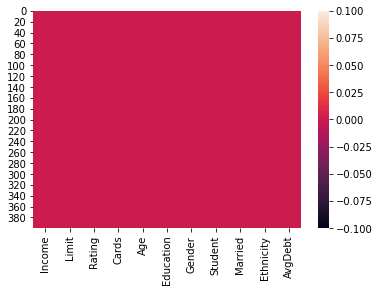

In [ ]:
# drawing at heatmap for spotting the missing values
sns.heatmap(df.isna())

The dataset does not have any missing values. Each observation is fully described by our different feature,as the pandas method and the heatmap plot can show us.

In [ ]:
# check the duplicates: There is no duplicates.
duplicateRows = df[df.duplicated()]
print("Duplicate Rows except first occurrence based on all columns are :")
print(duplicateRows)

Duplicate Rows except first occurrence based on all columns are :
Empty DataFrame
Columns: [Income, Limit, Rating, Cards, Age, Education, Gender, Student, Married, Ethnicity, AvgDebt]
Index: []


No duplicated rows are reported. Each observation is thus unique in our dataframe.

### I.A.3 Splitting our features into categorical vs numerical dataframes for in-depth analysis

In [ ]:
# splitting the dataframe into continuous vs categorical features
# There are 7 continuous variables: 'Income', 'Limit', 'Cards', 'Age', 'Education', 'Rating' and target variable 'AvgDebt'
# There are 4 categorical variables: 'Gender', 'Student', 'Ethnicity', 'Married'

continuous = df.loc[:,(df.dtypes!=np.object)]
categorical = df.loc[:,(df.dtypes==np.object)]

print(continuous.shape)
print(categorical.shape)

(400, 7)
(400, 4)


## I.B. In-depth analysis of numerical variables

Let's then take a closer look at the numerical features : how can we describe then individually ? How do they interact with each other ? How do they influence the target variable ? 

### I.B.1 Individual understanding of numerical features

In [ ]:
continuous.describe()

,Income,Limit,Rating,Cards,Age,Education,AvgDebt
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,45.218885,4735.600000,354.940000,2.957500,55.667500,13.450000,520.015000
std,35.244273,2308.198848,154.724143,1.371275,17.249807,3.125207,459.758877
min,10.354000,855.000000,93.000000,1.000000,23.000000,5.000000,0.000000
25%,21.007250,3088.000000,247.250000,2.000000,41.750000,11.000000,68.750000
50%,33.115500,4622.500000,344.000000,3.000000,56.000000,14.000000,459.500000
75%,57.470750,5872.750000,437.250000,4.000000,70.000000,16.000000,863.000000
max,186.634000,13913.000000,982.000000,9.000000,98.000000,20.000000,1999.000000


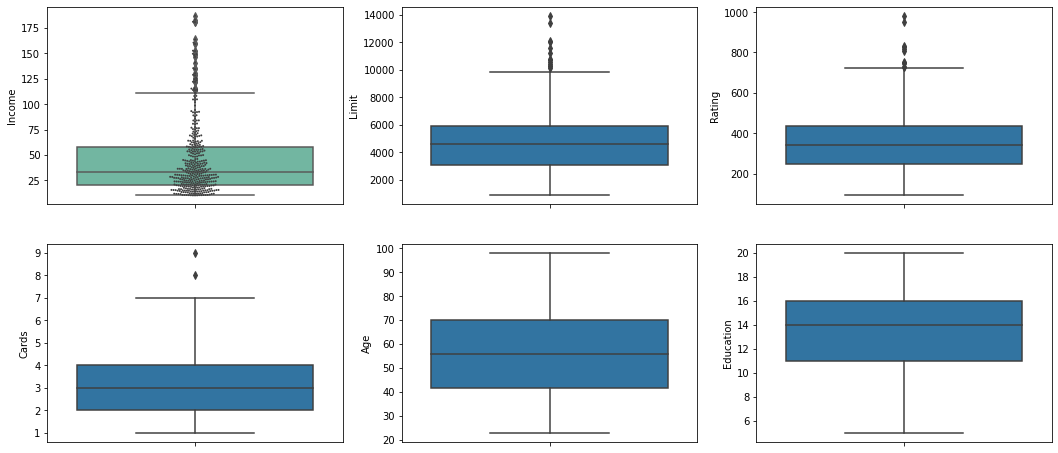

In [ ]:
# box plots of features
fig, axes = plt.subplots(nrows = 2,ncols = 3,figsize = (18, 8))
sns.boxplot(ax = axes[0,0], data = df, y = 'Income', hue = 'Student', palette = "Set2")
sns.swarmplot(ax = axes[0,0], data = df, y = 'Income', color = ".25", size = 2)

sns.boxplot(ax = axes[0,1], data = df, y = 'Limit')
sns.boxplot(ax = axes[0,2], data = df, y = 'Rating')
sns.boxplot(ax = axes[1,0], data = df, y = 'Cards')
sns.boxplot(ax = axes[1,1], data = df, y = 'Age')
sns.boxplot(ax = axes[1,2], data = df, y = 'Education')

When representing each numerical feature's distribution with a box plot , we can easily spot outliers for Income, Cards and Limit and Rating. The most extreme and frequent outliers are reached by the Income variable.

We will keep this insight in mind when we will prepare the data for modelling.

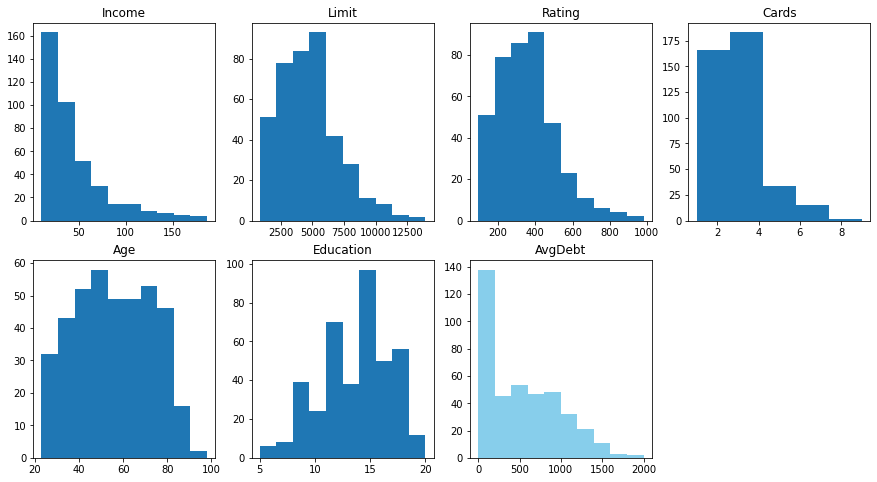

In [ ]:
# histogram-for income
fig, axes = plt.subplots(nrows = 2,ncols = 4,figsize = (15, 8))
axes[0,0].hist(x = continuous['Income'])
axes[0,0].set_title('Income')

axes[0,1].hist(x = continuous['Limit'])
axes[0,1].set_title('Limit')

axes[0,2].hist(x = continuous['Rating'])
axes[0,2].set_title('Rating')

axes[0,3].hist(x = continuous['Cards'], bins = 5)
axes[0,3].set_title('Cards')

axes[1,0].hist(x = continuous['Age'])
axes[1,0].set_title('Age')

axes[1,1].hist(x = continuous['Education'])
axes[1,1].set_title('Education')

axes[1,2].hist(x = continuous['AvgDebt'],color = "skyblue")
axes[1,2].set_title('AvgDebt')

fig.delaxes(axes[1][3])


The same conclusion as the one from the box plots can be drawn when plotting the distributions with histograms : Income, Limit, Rating and Cards are right-skewed, thus highlighting the presence of extreme positive values. 

If looking at our target variable "AvgDebt" we also notice that the distribution is right-skewed. However, the most frequent values are the minimal ones. 

Again, this presence of outliers will need to be tackled during the data preparation step: they can really influence the fitting process of the regression line, thus leading to overfitting problems. 

### I.B.2 Explanatory power of each numerical features on AvgDebt with t-tests & univariate regressions 

Estimating a regression model using a single feature can help us understand how strong this feature can contribute in predicting our target variable. 

Using the statsmodel package, we can loop through the numerical features and fit an univariate regression model to estimate AvgDebt. 

Regressing AvgDebt on Cards                             OLS Regression Results                            
Dep. Variable:                AvgDebt   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     2.997
Date:                Fri, 05 Mar 2021   Prob (F-statistic):             0.0842
Time:                        12:51:10   Log-Likelihood:                -3017.9
No. Observations:                 400   AIC:                             6040.
Df Residuals:                     398   BIC:                             6048.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    434.2861   

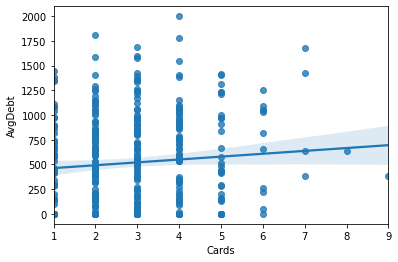

Regressing AvgDebt on Limit                             OLS Regression Results                            
Dep. Variable:                AvgDebt   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     1148.
Date:                Fri, 05 Mar 2021   Prob (F-statistic):          2.53e-119
Time:                        12:51:10   Log-Likelihood:                -2748.0
No. Observations:                 400   AIC:                             5500.
Df Residuals:                     398   BIC:                             5508.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -292.7905   

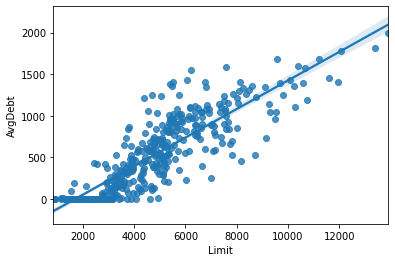

Regressing AvgDebt on Age                             OLS Regression Results                            
Dep. Variable:                AvgDebt   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                  0.001340
Date:                Fri, 05 Mar 2021   Prob (F-statistic):              0.971
Time:                        12:51:11   Log-Likelihood:                -3019.4
No. Observations:                 400   AIC:                             6043.
Df Residuals:                     398   BIC:                             6051.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    517.2922     

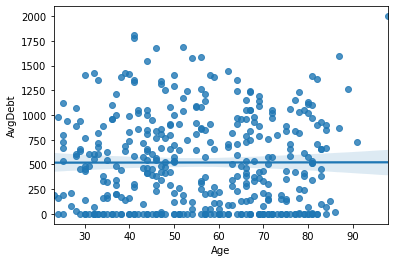

Regressing AvgDebt on Rating                             OLS Regression Results                            
Dep. Variable:                AvgDebt   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     1168.
Date:                Fri, 05 Mar 2021   Prob (F-statistic):          1.90e-120
Time:                        12:51:11   Log-Likelihood:                -2745.4
No. Observations:                 400   AIC:                             5495.
Df Residuals:                     398   BIC:                             5503.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -390.8463  

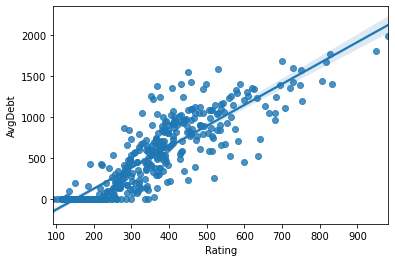

Regressing AvgDebt on Income                             OLS Regression Results                            
Dep. Variable:                AvgDebt   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     109.0
Date:                Fri, 05 Mar 2021   Prob (F-statistic):           1.03e-22
Time:                        12:51:11   Log-Likelihood:                -2970.9
No. Observations:                 400   AIC:                             5946.
Df Residuals:                     398   BIC:                             5954.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    246.5148  

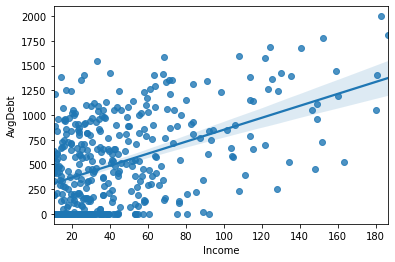

Regressing AvgDebt on Education                             OLS Regression Results                            
Dep. Variable:                AvgDebt   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                   0.02587
Date:                Fri, 05 Mar 2021   Prob (F-statistic):              0.872
Time:                        12:51:12   Log-Likelihood:                -3019.3
No. Observations:                 400   AIC:                             6043.
Df Residuals:                     398   BIC:                             6051.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    535.966

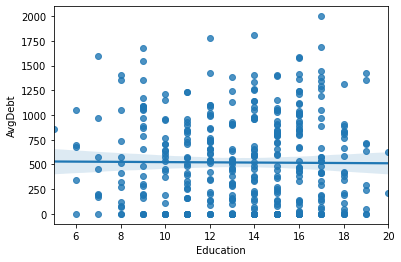

In [ ]:
#loop to regress AvgDebt on all the numerical features
for feature in ['Cards', "Limit", "Age", 'Rating', 'Income', 'Education']: 
  model = ols('AvgDebt ~ {}'.format(feature), data = continuous)
  results = model.fit()
  print("Regressing AvgDebt on {}".format(feature),  results.summary(),"\n")
  sns.regplot(x = '{}'.format(feature), y = 'AvgDebt', data = continuous)
  plt.plot()
  plt.show() 

Through all the regression outputs we obtain, we shall pay attention to these 2 metrics : 

*   the p-value of the t-test peformed on the estimation of the feature coefficient, telling us how strong/significant the role of the feature is in predicting AvgDebt
*   the R² metric showing us the percentage of AvgDebt variance explained by the feature 



So far, we can see that : 


*   Rating and Limit variables both individually explain more than 70% of AvgDebt variance. The p-values associated to their t-tests are both below 0.05, showing strong significance of their roles. They will be both useful when building the predictive model. 
*   Education, Age and Cards shows poor metrics : their p-values are strongly above 0.05 and their R² metrics are really low. They won't have a large explanatory power on AvgDebt.
*   The Income feature shows a small variance explanation of AvgDebt (R² of 0.20), but seems to have a significant role to play for estimating the relationship aiming at predicting AvgDebt : we strongly reject the null hypothesis stating that its coefficient estimate is null. (p-value really small)






### I.B.3 Analysing relationships between numerical features

After having studied the individual behaviours and interactions with AvgDebt of our numerical features, we may compare these features together. Are they similar ? Do they compete with each other ? How do they both interact with the target variable?

These questions can be solved through Pearson's correlation coefficients and scatter plots.

In [ ]:
continuous.corr()

,Income,Limit,Rating,Cards,Age,Education,AvgDebt
Income,1.000000,0.792088,0.791378,-0.018273,0.175338,-0.027692,0.463656
Limit,0.792088,1.000000,0.996880,0.010231,0.100888,-0.023549,0.861697
Rating,0.791378,0.996880,1.000000,0.053239,0.103165,-0.030136,0.863625
Cards,-0.018273,0.010231,0.053239,1.000000,0.042948,-0.051084,0.086456
Age,0.175338,0.100888,0.103165,0.042948,1.000000,0.003619,0.001835
Education,-0.027692,-0.023549,-0.030136,-0.051084,0.003619,1.000000,-0.008062
AvgDebt,0.463656,0.861697,0.863625,0.086456,0.001835,-0.008062,1.000000


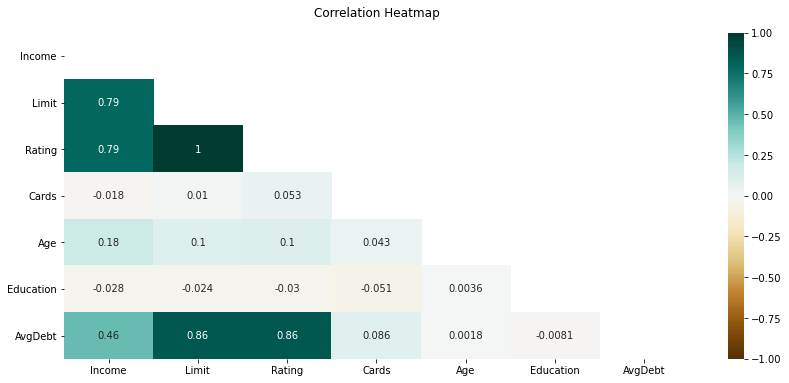

In [ ]:
# 'Income' paired with 'Limit', and 'income' paired with 'Rating' show high correlation to each other, 
# which can cause multicollinearity and detriorate the model's performancbe.
plt.figure(figsize=(14, 6))
mask = np.triu(np.ones_like(continuous.corr(), dtype=np.bool))
heatmap = sns.heatmap(continuous.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', pad=16);

The heatmap showing the different Person's correlation coefficients allows us to quickly identify highly correlated features. 

At first glance, there is not strong negative correlation between the variable. 

However, Rating and Limit are perfectly correlated. This tells us that people who can be at 1 unit above the average credit rating will be above the average credit limit by 1 unit as well. 

Income is less highly correlated with Rating and Limit than the two are together, but a correlation of 0.8 remains consequent. 

The other features shows weak correlation or casi-null correlations

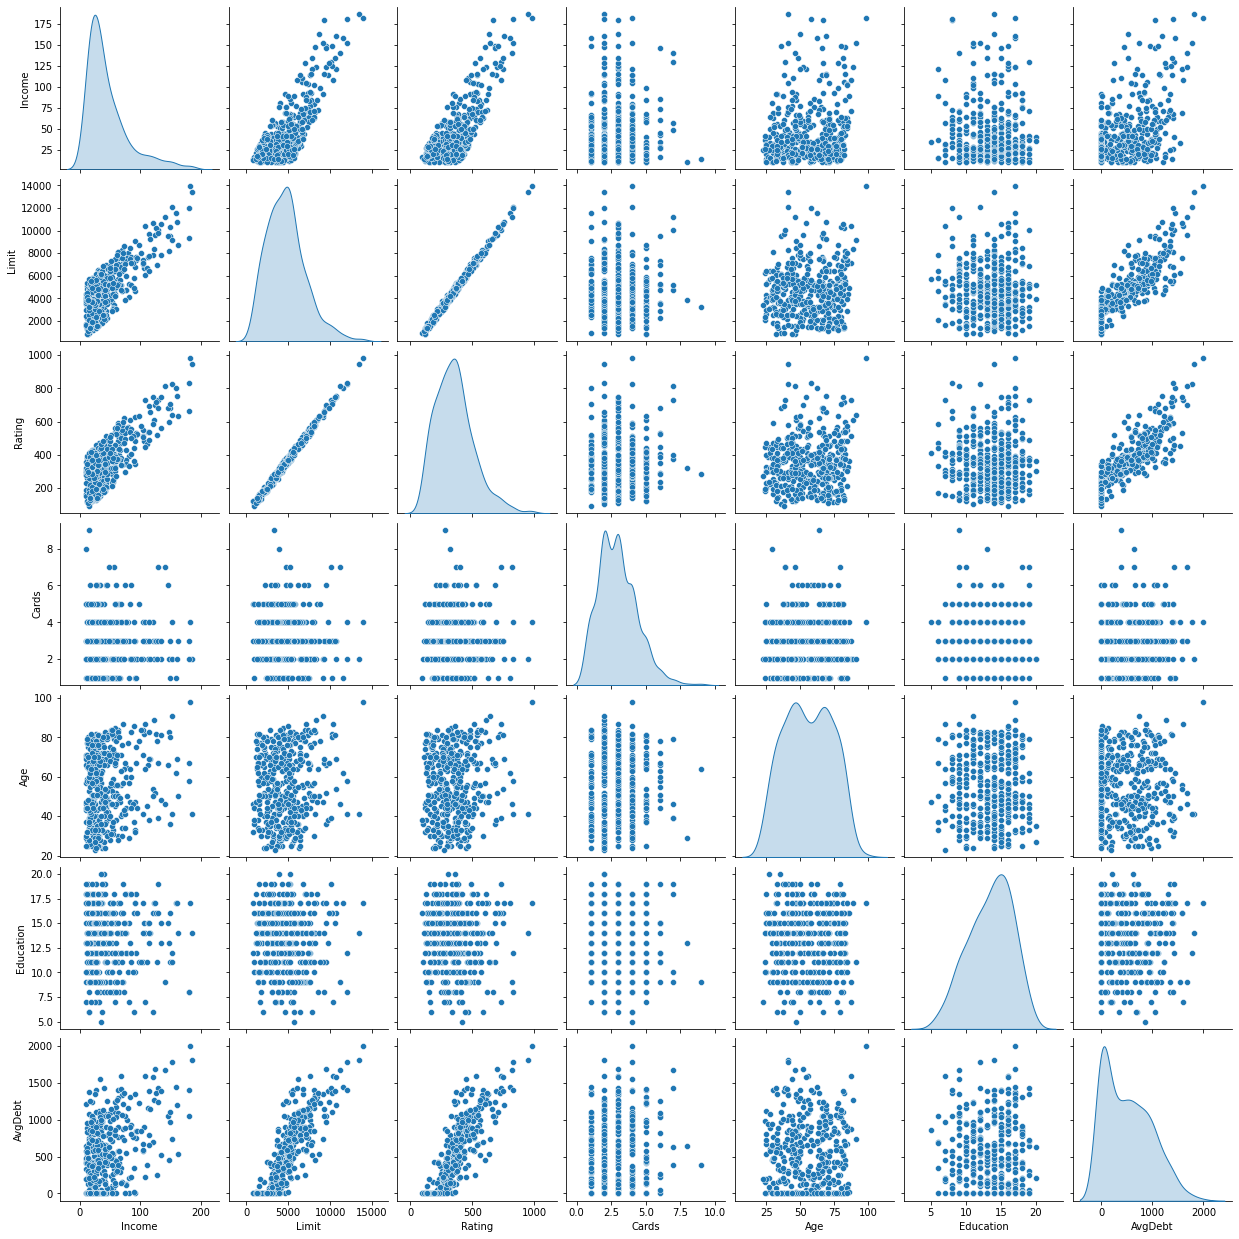

In [ ]:
sns.pairplot(continuous, diag_kind = 'kde')
plt.show()

Looking at the scatter plot matrix above, we can see the same correlation patterns observed on the heatmap. The scatter plot between Credit and Limit is almost a straight line, showing that the features are perfectly "moving" together. 

When building a regression model, highly correlated features shall be handled. 

In fact, it introduces multicolinearity in the linear relationship we are trying to build : the standard errors of the correlated feature coefficients will increase, leading to some of them being found not signficantly different from 0. In other words, keeping highly correlated features in a linear model can totally underestimate the role of these features in predicting the target.

## I.C. In-depth analysis of categorical features

Let's now focus our understanding on the categorical features : their behaviours, their relationships and interactions with the target variable



### I.C.1 Individual understanding of categorical features

In [ ]:
categorical.describe()

,Gender,Student,Married,Ethnicity
count,400,400,400,400
unique,2,2,2,3
top,Female,No,Yes,Caucasian
freq,207,360,245,199


Most of the categorical features are binary, except for the Etnicity variable which has 3 categories.  

Text(0.5, 1.0, 'Ethnicity')

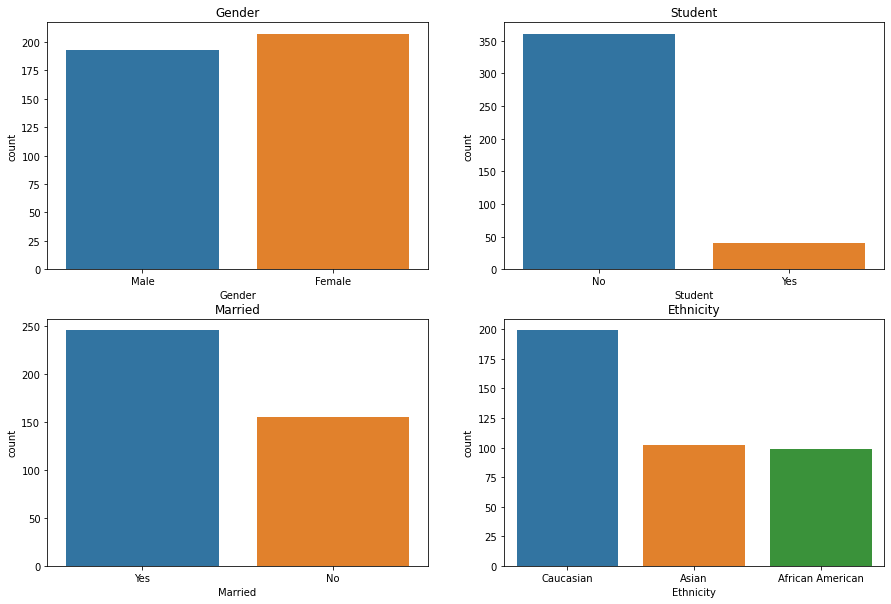

In [ ]:
#outputing countplots for each categorical feature
fig, axes = plt.subplots(nrows = 2,ncols = 2,figsize = (15, 10))
sns.countplot(ax=axes[0,0],data=categorical,x="Gender")
axes[0,0].set_title('Gender')

sns.countplot(ax=axes[0,1],data=categorical,x="Student")
axes[0,1].set_title('Student')

sns.countplot(ax=axes[1,0],data=categorical,x="Married")
axes[1,0].set_title('Married')

sns.countplot(ax=axes[1,1],data=categorical,x="Ethnicity")
axes[1,1].set_title('Ethnicity')

Looking at the different countplots, we can state that Student is the most imbalanced feature.
 

### I.C.2 Explanatory power of each cateogorical features on AvgDebt with two-sample t tests, ANOVA  & univariate regressions 

As mentioned earlier with numerical features, univariate regressions are useful to understand the explanatory power of a particular feature. 

When dealing with categorical features, univariate regressions can also provide group comparaisons, by confronting the significance of each classes on the target variable within a categorical feature. 
In fact, regressing our label on a categorical variable will create as many dummies variables (minus 1) as available categories. 

If we have 2 groups, we look at the p-value of a two-sample t-test. If we are dealing with more than 2 categories, we look at the p-value of an ANOVA. However, when using regression tools for group comparaison, both tests are called a F-test

Text(0.5, 1.0, 'Ethnicity')

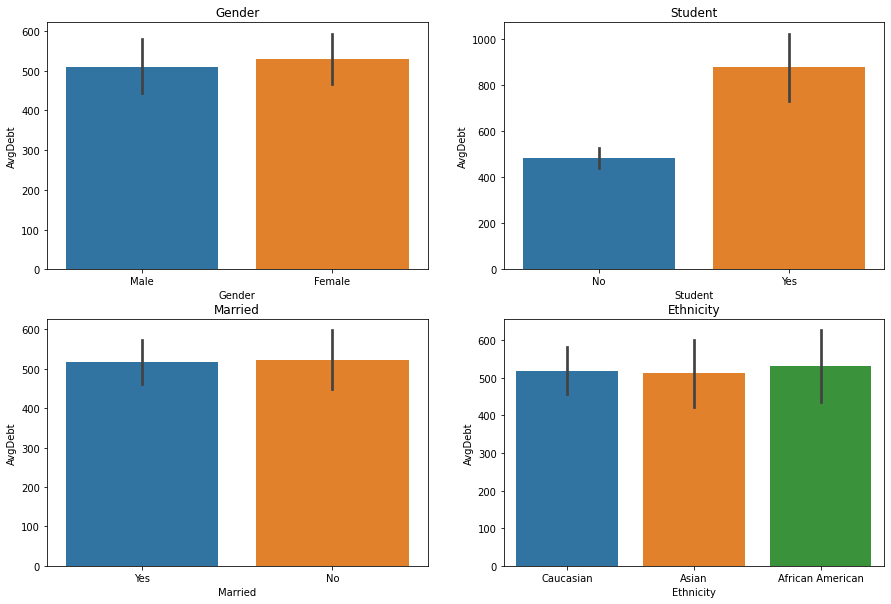

In [ ]:
#showing the relationship of each class with AvgDebt by categorical feature

# 'Student' visually shows meanigful deviation of 'AvgDebt'.
# It needs to be further verified by t-test
fig, axes = plt.subplots(nrows = 2,ncols = 2,figsize = (15, 10))
sns.barplot(ax=axes[0,0],data=df,y="AvgDebt",x="Gender")
axes[0,0].set_title('Gender')

sns.barplot(ax=axes[0,1],data=df,y="AvgDebt",x="Student")
axes[0,1].set_title('Student')

sns.barplot(ax=axes[1,0],data=df,y="AvgDebt",x="Married")
axes[1,0].set_title('Married')

sns.barplot(ax=axes[1,1],data=df,y="AvgDebt",x="Ethnicity")
axes[1,1].set_title('Ethnicity')


Looking at the graph above, we notice a strong deviation between the two classes of the Student variable. 
Being a student seems to increase the average credit card debt than not being a student. But is this difference significant ? 

Let's loop through each categorical feature and perform a F-test through the regression.

In [ ]:
for feature in ['Gender', 'Student', 'Ethnicity', 'Married'] : 
  model = ols('AvgDebt ~ C({})'.format(feature), data=df).fit()
  anova_table = sm.stats.anova_lm(model, typ=2)
  print("F-test performed on {}".format(feature))
  print(anova_table)
  print("\n")

F-test performed on Gender
                 sum_sq     df         F    PR(>F)
C(Gender)  3.889191e+04    1.0  0.183616  0.668516
Residual   8.430102e+07  398.0       NaN       NaN


F-test performed on Student
                  sum_sq     df          F        PR(>F)
C(Student)  5.658372e+06    1.0  28.622116  1.487734e-07
Residual    7.868154e+07  398.0        NaN           NaN


F-test performed on Ethnicity
                    sum_sq     df         F    PR(>F)
C(Ethnicity)  1.845420e+04    2.0  0.043443  0.957492
Residual      8.432146e+07  397.0       NaN       NaN


F-test performed on Married
                  sum_sq     df         F    PR(>F)
C(Married)  2.714775e+03    1.0  0.012811  0.909939
Residual    8.433720e+07  398.0       NaN       NaN




As we can see, the most significant F-test is performed on the Student feature. The p-value is really small and below 0.05, meaning that the difference in average credit card debt between Sutdents and non-student is statistically different from 0. 

This also means that the dummy variable resulting from the regression of AvgDebt on Student is significant, and will play a strong role in predicting our target. 

Yet, we don't observe other strong p-value on the F-tests performed on the remaining categorical feature. This lets us to think that they will play a less important role in fitting our multivariate regression line than "Student" feature. 

### I.C.3 Analysing interactions between categorical features

As we previously said for the numerical features, it is important to check for multicolinearity in our features when fitting a linear model. 

When dealing with categorical features, Pearson's correlation coefficient cannot be computed. However, we can measure their association, i.e the occurences of their values. 
We qualified two features as perfectly associated when the probability of having a category of a feature will depend on the probility of having a category from the other feature. In other words, the distribution of the categories are dependent.

Cramer's V can help us check the significance of association between categorical features.

Cramer's V = 

$$ \sqrt \frac{ X^2} {n\times min((r-1), (s-1) }$$

It gives us the following values : 

- v = 0: variables not associated
- V = 1: Perfectly associated
- V < 0.25: weak association
- V > 0.75: strong association
- 0.25 < V < 0.75: moderate association

In [ ]:
# label encoding
# The categorical variables are encoded to integers
label = preprocessing.LabelEncoder()
categorical_encoded = pd.DataFrame() 

for i in categorical.columns:
  categorical_encoded[i]=label.fit_transform(categorical[i])
    
categorical_encoded.head()

,Gender,Student,Married,Ethnicity
0,1,0,1,2
1,0,1,1,1
2,1,0,0,1
3,0,0,0,1
4,1,0,1,2


In [ ]:
# Building the Cramer's V function
def cramers_V(var1,var2):
    crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
    stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
    obs = np.sum(crosstab) # Number of observations
    mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
    return (stat/(obs*mini))

In [ ]:
# Building the matrix
rows= []

for var1 in categorical_encoded:
    col = []
    for var2 in categorical_encoded :
        cramers =cramers_V(categorical_encoded[var1], categorical_encoded[var2]) # Cramer's V test
        col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V
    rows.append(col)
  
cramers_results = np.array(rows)
df_cramer = pd.DataFrame(cramers_results, columns = categorical_encoded.columns, index = categorical_encoded.columns)

df_cramer

,Gender,Student,Married,Ethnicity
Gender,0.99,0.00,0.00,0.00
Student,0.00,0.97,0.00,0.00
Married,0.00,0.00,0.99,0.01
Ethnicity,0.00,0.00,0.01,1.00


Text(0.5, 1.0, "Cramer's V heatmap")

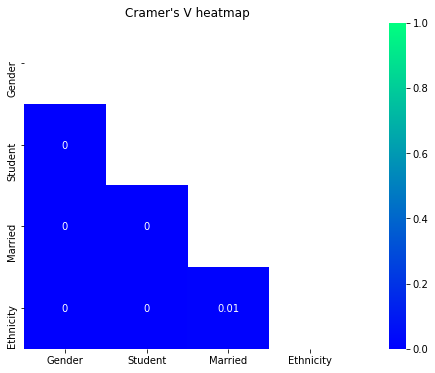

In [ ]:
# Add a heatmap to the matrix
mask = np.zeros_like(df_cramer, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(14, 6))
heatmap = sns.heatmap(df_cramer, mask = mask, vmin = 0, vmax = 1, square = True, annot = True, cmap = 'winter')
heatmap.set_title("Cramer's V heatmap" )

When comparing the association between the categorical variables, no strong values are output.  All categorical variables have almost no association to one another.

We then won't remove any of them to avoid any multicolinearity issues. 

## I.D. Analysing interactions between numerical and categorical variables

Finally, after having studied independently numerical and categorical features, it is now time to confront them to understand their impact on our target variable



### I.D.1 Pair plots by categorical variables

Using pair plots, we can visualize pairwise relationships between our numerical features, for different classes of a cateogorical feature. 

Wer previously found that the Student feature seems to have a consequent explanatory power on AvgDebt. Let's then see how does Student variable behaves in the interactions between our numerical features and AvgDebt.

Text(0.5, 0.98, "'Continuous variables vs. AvgDebt by Categorical variable 'Student'")

<Figure size 1296x432 with 0 Axes>

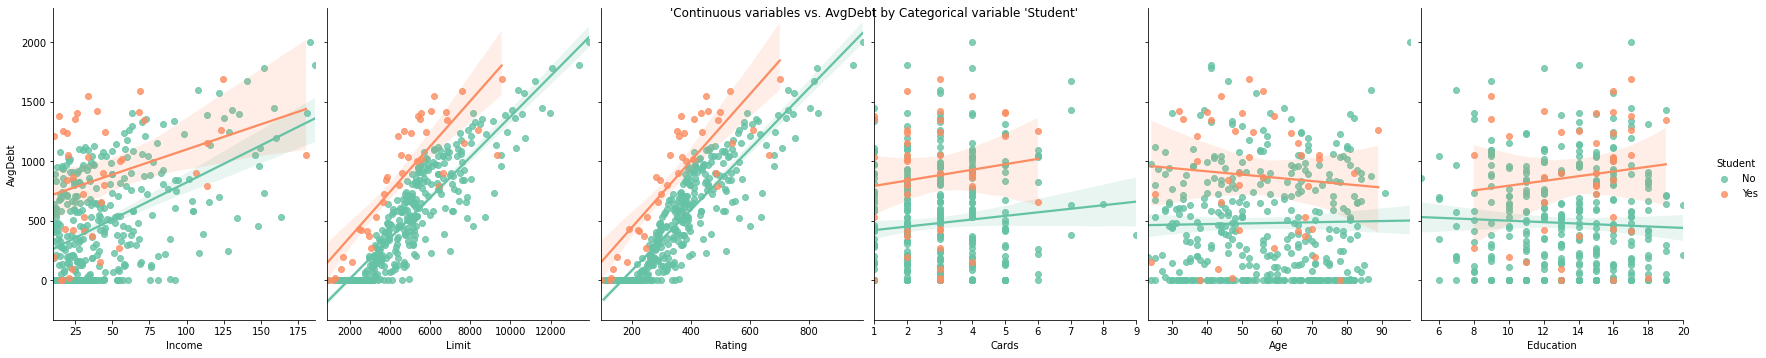

In [ ]:
#pairplot for student vs non student population understanding 
plt.figure(figsize=(18, 6))
sns.pairplot(data = df, x_vars=["Income", "Limit", "Rating", "Cards", "Age", "Education"], y_vars=["AvgDebt"],
             hue="Student", height=5, aspect=.8, kind="reg", palette = "Set2")
plt.suptitle("'Continuous variables vs. AvgDebt by Categorical variable 'Student'")

#Students tend to have more debt in all features than non students do
#Correlation of 'Education' and 'AvgDebt' for Non student is negative while that for student is positive. 

Globally we notice that being a student results in having higher average credit card debt with respect to all numerical features. 

Most interesting facts can be found we looking at the scatter plots for Rating (or Limit since they are strongly correlated) and Income. 

In fact, students keep having higher credit debt than non student even though their income increases. AvgDebt and Income being moderatly correlated, an increase in the income will result in most cases in a higher average credit card debt for students. 

This discrimination can strongly be applied when looking at the interaction between Limit and AvgDebt. The two features are strongly correlated : as long as the credit limit increases, students will always get higher credit debt than non students. 

This analysis thus strenghten the role that the dummy variable "being a student" will play in predicting AvgDebt.

### I.D.2 Significant interactions between the features

Text(0.5, 0.98, "'Continuous variables vs. AvgDebt by Categorical variable 'Student'")

<Figure size 1296x432 with 0 Axes>

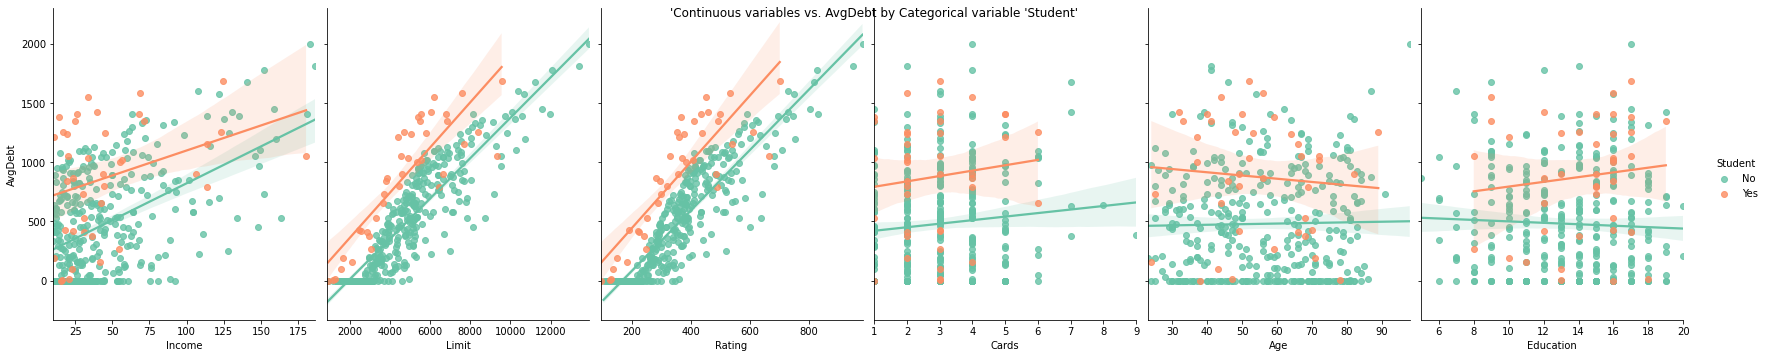

In [ ]:
#interaction between features
plt.figure(figsize=(18, 6))
sns.pairplot(data = df, x_vars=["Income", "Limit", "Rating", "Cards", "Age", "Education"], y_vars=["AvgDebt"],
             hue="Student", height=5, aspect=.8, kind="reg", palette = "Set2")
plt.suptitle("'Continuous variables vs. AvgDebt by Categorical variable 'Student'")

#Students tend to have more debt in all features than non students do
#Correlation of 'Education' and 'AvgDebt' for Non student is negative while that for student is positive. 

Students tend to have more debt in all features than non students do.


> ->Correlation of 'Education' and 'AvgDebt' for Non student is negative while that for student is positive.


> ->This needs to be further tested by statistical approach







In [ ]:
#checking the significance of interaction between the features
model = ols('AvgDebt ~Rating+Income+Age+C(Student)+C(Student)*Rating + C(Student)*Income', data = df)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                AvgDebt   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     1350.
Date:                Fri, 05 Mar 2021   Prob (F-statistic):          9.32e-259
Time:                        12:51:41   Log-Likelihood:                -2404.7
No. Observations:                 400   AIC:                             4823.
Df Residuals:                     393   BIC:                             4851.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                 -531.2616     21.080    -25.203      0.000    -572.704    -489.819
C(Student)[T.Yes]          209.7950     45.896      4.571      0.000     119.563     300.028
Rating                       3.8903      0.056     69.802      0.000       3.781       4.000
C(Student)[T.Yes]:Rating     0.9415      0.178      5.298      0.000       0.592       1.291
Income                      -7.5054      0.250    -30.002      0.000      -7.997      -7.014
C(Student)[T.Yes]:Income    -2.6697      0.699     -3.818      0.000      -4.044      -1.295
Age                         -0.5720      0.295     -1.941      0.053      -1.151       0.007
==============================================================================
Omnibus:                       11.457   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               11.694
Skew:                           0.394   Prob(JB):                      0.00289
Kurtosis:                       2.716   Cond. No.                     3.67e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.67e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Looking at the t-tests performed on the coefficient estimation for C(Student)*Rating and C(Student)*Income, we conclude that both features are significant in explaining AvgDebt. (p-values really small). The interactions between Student & Rating, and Student & Income are significant : being a Student increases the marginal effect of Income in explaining the average credit card debt for instance. (coefficient > 0). We thus confirm statistically what we observed in the graphs above.


<a id='II'></a>

# II. Data Preparation

The Exploratory Data Analysis being finished, we may prepare the dataset for modelling based on what we've discovered so far. 

In this section we will : 


*   Deal with outliers we detected 
*   Apply feature selection based on the analysis we conducted in I. 
*   Perform Feature Engineering for futher model candidates 






Each preparation will be made on a different dataframe object called "df_cleaned", which will be a copy of our original dataframe.

## II.A Handling Outliers

### II.A.1 Detecting univariate outliers

Our main objective is to first detect the univariate outliers with a program and capture their location on the dataset. 

We can achieve this process by standardizing the distribution of a numerical feature, and store each observation's index for which the standardized value is not between -2 and 2, i.e which does not belong to 95% of the value.

Let's apply this process for Limit, Cards, Rating and Income, the features for which we previously detected extreme values graphically. (I.B.1)

In [ ]:
#functions to detect, visualize and capture outliers indices
from sklearn import preprocessing
def outlier_detection(x):
  X = np.log(x.values.astype(float))
  Scaler = preprocessing.StandardScaler()
  scaled = pd.DataFrame(Scaler.fit_transform(X))
  plt.plot(scaled,'o')
  plt.axhline(y=2)
  plt.axhline(y=-2);
  
def outlier_indices(x,limit):
  X = np.log(x.values.astype(float))
  Scaler = preprocessing.StandardScaler()
  scaled = pd.DataFrame(Scaler.fit_transform(X))
  return sorted(np.concatenate( (np.where(scaled>limit)[0],np.where(scaled<-limit)[0])))

Detecting outliers for Limit
None


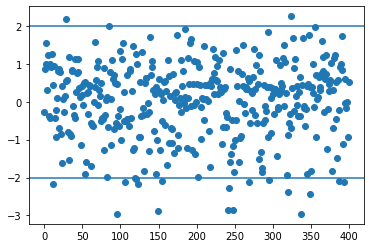



Detecting outliers for Cards
None


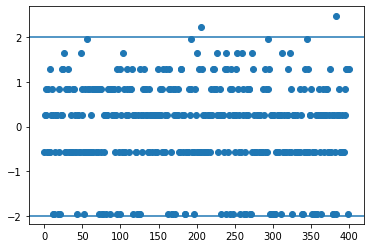



Detecting outliers for Rating
None


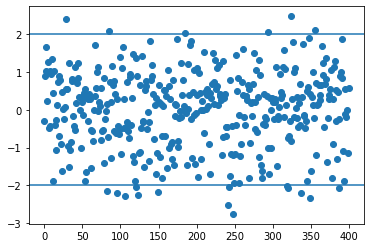



Detecting outliers for Income
None


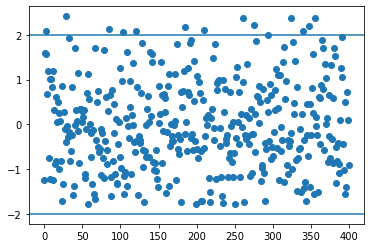



Number of observations presenting outliers on one or several studied features: 36


In [ ]:
#capturing the rows presenting outliers on one or many features we are studying:
outliers_indices = []
for feature in ['Limit', 'Cards', 'Rating', 'Income']:
  print("Detecting outliers for {}".format(feature))
  print(outlier_detection(df[[feature]]))
  plt.show()
  outliers = outlier_indices(df[[feature]],2)
  for indice in outliers:
    if indice not in outliers_indices:
      outliers_indices.append(indice)
  print('\n')

print("Number of observations presenting outliers on one or several studied features:", len(outliers_indices))


### II.A.2 Dropping outliers


36 observations of our dataset present outliers in a least one feature among Cards, Limit, Rating and Income. 

It represents 9% of our dataset. We will opt for dropping them in our new data frame object "df_cleaned".

In [ ]:
#dropping our 36 observations presenting outliers 

df_cleaned= df.copy()
df_cleaned = df_cleaned.drop(outliers_indices, axis=0)

## II.B Feature Selection

When fitting a multivariate regression line, reducing the dimension of our dataset is always preferable : the simpliest models often tend to be the best ones. 

To do so, we can directly select our features in our df_cleaned dataframe object.



###II.B.1 Dropping highly correlated features

We previously identified highly correlated numerical features in I.B and exposed why it is important to drop them for multicolinearity reasons. 

Limit and Rating where perfectly correlated, we thus choose to drop the Limit feature (for model interpretation purpose)

In [ ]:
df_cleaned = df_cleaned.drop(['Limit'], axis=1)

We did not spott any strongly associated categorical features, so we keep all of them.

### II.B.2 Removing non-significant features with statsmodel

To see which feature will not have a strong explanatory power on AvgDebt, we can perform a simple multivariate regression analysis by using all of our features we selected so far, and the cleaned dataframe we prepared. 

The variables for which the estimated coefficients are statistically different from 0 (p-value of the t-test below 0.05) shall be kept

In [ ]:
from statsmodels.formula.api import ols
model = ols('AvgDebt ~Rating+Income+Age+Education+Cards+C(Ethnicity)+C(Gender)+C(Student)+C(Married)', data = df_cleaned)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                AvgDebt   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     792.9
Date:                Fri, 05 Mar 2021   Prob (F-statistic):          4.86e-235
Time:                        12:51:42   Log-Likelihood:                -2153.7
No. Observations:                 364   AIC:                             4329.
Df Residuals:                     353   BIC:                             4372.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                  -601.8761     33.071    -18.200      0.000    -666.916    -536.836
C(Ethnicity)[T.Asian]        23.8535     13.714      1.739      0.083      -3.119      50.826
C(Ethnicity)[T.Caucasian]    18.0162     11.943      1.509      0.132      -5.472      41.504
C(Gender)[T.Male]            11.0321      9.607      1.148      0.252      -7.862      29.927
C(Student)[T.Yes]           441.3088     16.245     27.165      0.000     409.359     473.258
C(Married)[T.Yes]           -11.6718     10.011     -1.166      0.244     -31.361       8.018
Rating                        4.1017      0.053     77.719      0.000       3.998       4.205
Income                       -8.0980      0.245    -33.066      0.000      -8.580      -7.616
Age                          -0.7706      0.287     -2.683      0.008      -1.336      -0.206
Education                     0.1623      1.533      0.106      0.916      -2.853       3.178
Cards                         1.6649      3.681      0.452      0.651      -5.575       8.905
==============================================================================
Omnibus:                       21.051   Durbin-Watson:                   1.894
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.121
Skew:                           0.607   Prob(JB):                     9.54e-06
Kurtosis:                       3.225   Cond. No.                     2.68e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.68e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Looking at the regression output , we can clearly see that the following features have no significant impacts in explaining our target variable : (from top non-signficant ones to close to be significant) 


1. Education (has the highest p-value)
2. Cards 
3. Binary variable "Gender"
4. Binary variable "Married"
5. Caucasian dummy variable from the Ethnicity feature
6. Asian dummy variable from the Ethnicity feature (close to be significant with p-value of 0.08)

We thus chose to remove Education, Cards, Gender, Married and Ethnicity in our data preparation process. 









In [ ]:
df_cleaned = df_cleaned.drop(['Education', 'Cards', 'Gender', 'Married', 'Ethnicity'], axis=1)

## II.C Feature Engineering

To increase the performance of a model, it is sometimes useful to create new features. 
Even though it increases the dimension of the dataset, we may build new significant variables which will have a strong explanatory power in predicting our target.

### II.C.1 Creating polynomial features

One of the most classical features engineered for multivariate regression are polynomial variables. It can be done by adding the squared of an existing numericalfeature for instance. 

The purpose of creating such features is to perform a Polynomial regression. This non-linear technique can be used when we spot some curvature in a bivariate analysis between our label and a feature. (curvilinear relationship). 

Let's re-take a look at the different scatter plots we can have between our significant numerical features and AvgDebt 




Text(0.5, 0.98, "'Significant Continuous variables vs. AvgDebt")

<Figure size 1296x432 with 0 Axes>

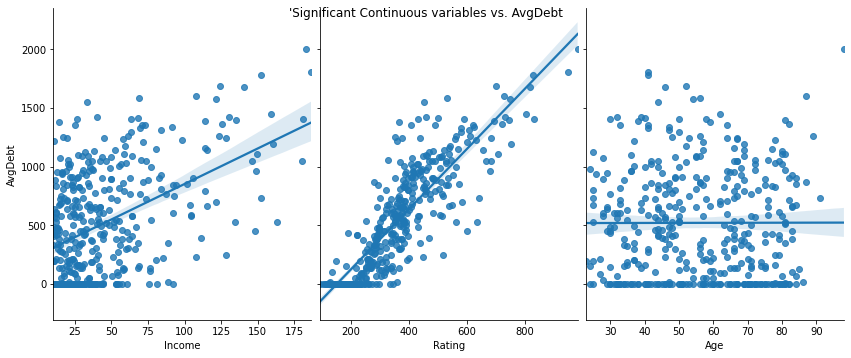

In [ ]:
#pairplot between our significant numerical features and AvgDebt
plt.figure(figsize=(18, 6))
sns.pairplot(data = df, x_vars=["Income", "Rating", "Age"], y_vars=["AvgDebt"],
            height=5, aspect=.8, kind="reg", palette = "Set2")
plt.suptitle("'Significant Continuous variables vs. AvgDebt")

We don't spot any curvature trend in Age variable, nor in Income feature. 

However, for the Rating feature, we can notice a slight curvilinear relationship with the label. We shall then focus on creating polynomial features based on Rating feature. 

 We previously saw in I.B.1 that Rating and AvgDebt had a strong positive correlation, but this association trend is not linear. Let's fit simple a regression line to show the non linearity using the Least squares estimate: 



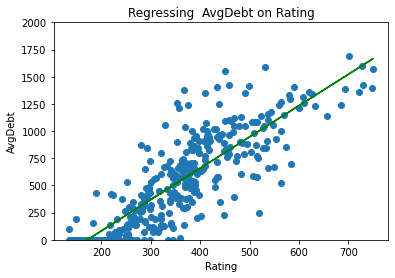

In [ ]:
x = df_cleaned['Rating']
y = df_cleaned['AvgDebt']
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

def fitline(x):
    return intercept + slope * x
plt.xlabel('Rating')
plt.ylabel('AvgDebt')
plt.title('Regressing  AvgDebt on Rating')
plt.plot(x,fitline(x),c = 'g')
plt.scatter(x,y)
plt.ylim(0, 2000)
plt.show()

Even though the straight line shows a good fit of the data, it does not capture the slight curvature relationship. 

Let's now try to  fit a quadratic line, by adding the square of Rating feature : 

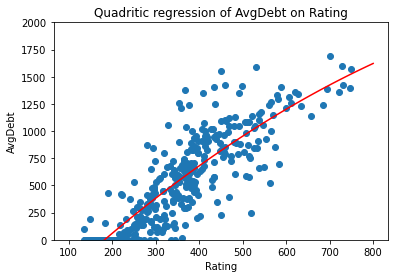

In [ ]:
plt.xlabel('Rating')
plt.ylabel('AvgDebt')
plt.title('Quadritic regression of AvgDebt on Rating')
p = np.poly1d(np.polyfit(x,y,2))
xp = np.linspace(100,800,100)
plt.plot(xp,p(xp),c = 'r')
plt.scatter(x,y)
plt.ylim(0, 2000)
plt.show()

Still, we capture some of the curvature in the data, but not in the optimal way. Let's then try a cubic regression, by adding the cube of Rating. 



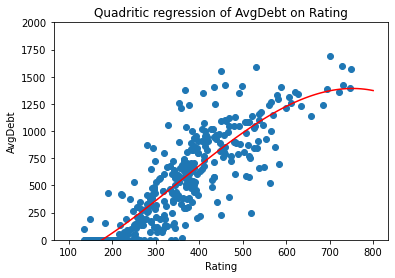

In [ ]:
plt.xlabel('Rating')
plt.ylabel('AvgDebt')
plt.title('Quadritic regression of AvgDebt on Rating')
p = np.poly1d(np.polyfit(x,y,3))
xp = np.linspace(100,800,100)
plt.plot(xp,p(xp),c = 'r')
plt.scatter(x,y)
plt.ylim(0, 2000)
plt.show()

Looking at the graph, it seems that we managed to capture this slight curvilinear relationship  observed in the scatter plot. We won't add other polynomial features with highest degrees, since we may overfit the data. 

Let's then create the cube and the square of the Rating feature

In [ ]:
df_cleaned["Rating_squared"]=df_cleaned['Rating']**2
df_cleaned["Rating_cube"]=df_cleaned['Rating']**3

In [ ]:
df_cleaned

,Income,Rating,Age,Student,AvgDebt,Rating_squared,Rating_cube
0,14.891,283,34,No,333,80089,22665187
1,106.025,483,82,Yes,903,233289,112678587
2,104.593,514,71,No,580,264196,135796744
4,55.882,357,68,No,331,127449,45499293
5,80.180,569,77,No,1151,323761,184220009
...,...,...,...,...,...,...,...
395,12.096,307,32,No,560,94249,28934443
396,13.364,296,65,No,480,87616,25934336
397,57.872,321,67,No,138,103041,33076161
398,37.728,192,44,No,0,36864,7077888


### II.C.3 Checking significance of the new features

The features we created so far will be tried when modelling in part III. For the moment, we shall verify whether or not they can have a significant role in predicting the average credit card debt. 

To do this, we can fit a simple multivariate regression as we did before with our significant variables and the new feature engineered: 

In [ ]:
from statsmodels.formula.api import ols
model = ols('AvgDebt ~Rating+Income+Age+C(Student)+Rating_squared+Rating_cube', data = df_cleaned)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                AvgDebt   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     2073.
Date:                Fri, 05 Mar 2021   Prob (F-statistic):          5.46e-274
Time:                        12:51:44   Log-Likelihood:                -2076.6
No. Observations:                 364   AIC:                             4167.
Df Residuals:                     357   BIC:                             4194.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           200.8600     63.430      3.167      0.002      76.117     325.603
C(Student)[T.Yes]   442.3751     12.914     34.256      0.000     416.978     467.772
Rating               -1.9382      0.516     -3.757      0.000      -2.953      -0.924
Income               -9.0969      0.213    -42.787      0.000      -9.515      -8.679
Age                  -0.9565      0.230     -4.165      0.000      -1.408      -0.505
Rating_squared        0.0143      0.001     10.721      0.000       0.012       0.017
Rating_cube       -9.812e-06   1.05e-06     -9.329      0.000   -1.19e-05   -7.74e-06
==============================================================================
Omnibus:                        4.420   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.110   Jarque-Bera (JB):                4.713
Skew:                          -0.153   Prob(JB):                       0.0948
Kurtosis:                       3.466   Cond. No.                     1.55e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.55e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The regression output shows us that coefficient estimates for the new features are statistically different from 0. These variables can play a strong role in predicting the amount of average debt . 

However, we shall monitor the generalization of our model to see how well it can perform on unseen data : this will be the objective in the next parts of the notebook. 



---





<a id='III'></a>

# III. Modelling and Validating with scikit-learn

So far, we have been fitting mutlivariate regressions for a statistical inference approach: the objective was to understand, select and even create features that could show strong significance in explaining the average credit card debt. 

Now it's time to train and evaluate models that could accuretly predict the credit card debt for any invidual given input information.

To do so, we shall pick candidates models following the data processing we did in II. The different model configurations will be as follow : 




*   Model 1 : a standard candidate. We will feed it with the original dataframe, and without selecting any feature. The idea is to have a base model for comparaion. 
*   Model 2 : an optimized candidate. We will construct it by applying all data prepation we exposed in II. (feature selection, outliers removal..)
*   Mode 3: an engineered candidate. We will uise the same data preparation as forModel 2,  but we will add the polynomial features. 








## III.A Presenting our Model validation pipeline

### III.A.1 The workflow 

Before diving into model buildings, let's first define the pipeline we will follow for training and evaluating our predictive models. 

The worflow will be as follow : 

**1.** Splitting our dataset to keep and independent test set

**2.**Preparing the data (if preparation required)

**3.**Performing a Cross-validation to anticipate how well the model will generalize on the independent test set, using the Mean Squared Error (MSE) as evaluation metric


**MSE** is defined as follow : the mean of the the error squared values:
$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)²$$
where $y_i$ represent the true label value of the ith observation and $\hat{y}_i$ being model prediction for that observation. $n$ represents the total number of observations on which we are evaluating. 

The lower our MSE, the better the predictive power of our model. 


 


### III.A.2 Defining required functions for the pipeline

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression


#function to define what will feed the model and apply common pre-processing 
def pre_processing(categorical, numerical, dataframe, test_size):
  X = dataframe[categorical+numerical]
  y = dataframe['AvgDebt']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = 101)
  X_train_categorical = X_train[categorical]
  X_test_categorical = X_test[categorical] 
  X_train_numerical = X_train[numerical]
  X_test_numerical = X_test[numerical]
  #encoding categorical features using One-hot-encoders, since scikit-learn does not support categorical data
  X_train_categorical = X_train[categorical]
  X_test_categorical = X_test[categorical] 
  X_train_categorical = pd.get_dummies(X_train_categorical, drop_first = True)
  X_test_categorical = pd.get_dummies(X_test_categorical, drop_first = True)


  #recombining train and test sets 
  X_train_categorical = X_train_categorical.reset_index(drop=True)
  X_test_categorical = X_test_categorical.reset_index(drop=True)
  X_train_numerical = X_train_numerical.reset_index(drop=True)
  X_test_numerical = X_test_numerical.reset_index(drop=True)
  X_train = pd.concat([X_train_categorical, X_train_numerical], axis=1)
  X_test = pd.concat([X_test_categorical, X_test_numerical], axis=1)
  return X_train, X_test, y_train, y_test

# function to get cross validation scores with respect to MSE evaluation metric  
def get_cv_scores_mse(model, X_train, y_train):
    scores = cross_val_score(model,
                             X_train,
                             y_train,
                             cv=10,
                             scoring='neg_mean_squared_error')

    return abs(scores) #get positive value since scikit-learn returns negative MSEs  


## III.B Training and validating the different model candidates

### III.B.1 Model 1: Basic model, used for comparaison

This model is the standard candidate. We basically feed it **with all our features** (expect Limit as it is perfectly correlated with Rating) ,using our original dataframe object 'df' on which we did not do any preparation

In [ ]:
#splitting and pre processing
categorical = ["Gender","Married", "Student", "Ethnicity" ]
numerical = ["Rating", "Cards", "Age", "Income", "Education"]
X_train_model1, X_test_model1, y_train_model1, y_test_model1  = pre_processing(categorical, numerical, df, 0.20)


#training 
model_1 = LinearRegression().fit(X_train_model1, y_train_model1)

#validating
scores_model_1 = get_cv_scores_mse(model_1, X_train_model1, y_train_model1)

### III.B.2  Model 2: Using selected features and outliers removal

This candidate will integrate the data preparation processes we develop in II. 
It will then : 

*   be fed with the significant variables we selected 
*   modelled without observations presenting outliers

We thus train and evaluate it using the df_cleaned dataframe object from II. 

The train/test split ratio will need to be higher, in order to have the train size on which we evaluated our standard model (320 observations)
We will pick 0.22 so we ensure the same test size. 



In [ ]:
#splitting and pre processing
categorical = ["Student" ]
numerical = ["Rating", "Age", "Income"]
X_train_model2, X_test_model2, y_train_model2, y_test_model2  = pre_processing(categorical, numerical, df_cleaned, 0.22)


#training 
model_2 = LinearRegression().fit(X_train_model2, y_train_model2)

#validating
scores_model_2 = get_cv_scores_mse(model_2,X_train_model2, y_train_model2)

### III.B.3  Model 3: Using Polynomial features




This model candidate will integrate the feature engineered at II.C. 
It will use what we call Polynomial regression, by adding quadratic and cubic terms based on the feature "Rating". 
The goal is to try to capture more curvature in the data, and thus trying to have a better fit. 

In [ ]:
#splitting and pre processing
categorical = ["Student"]
numerical = ["Rating", "Age", "Income", "Rating_squared", "Rating_cube"]
X_train_model3, X_test_model3, y_train_model3, y_test_model3  = pre_processing(categorical, numerical, df_cleaned, 0.22)

#training 
model_3 = LinearRegression().fit(X_train_model3, y_train_model3)

#validating 
scores_model_3 = get_cv_scores_mse(model_3,X_train_model3, y_train_model3)

## III.C Checking the cross-validated results

### III.C.1 Visualizing all results across the folders

Text(0.5, 1.0, '10-fold cross validation performance')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


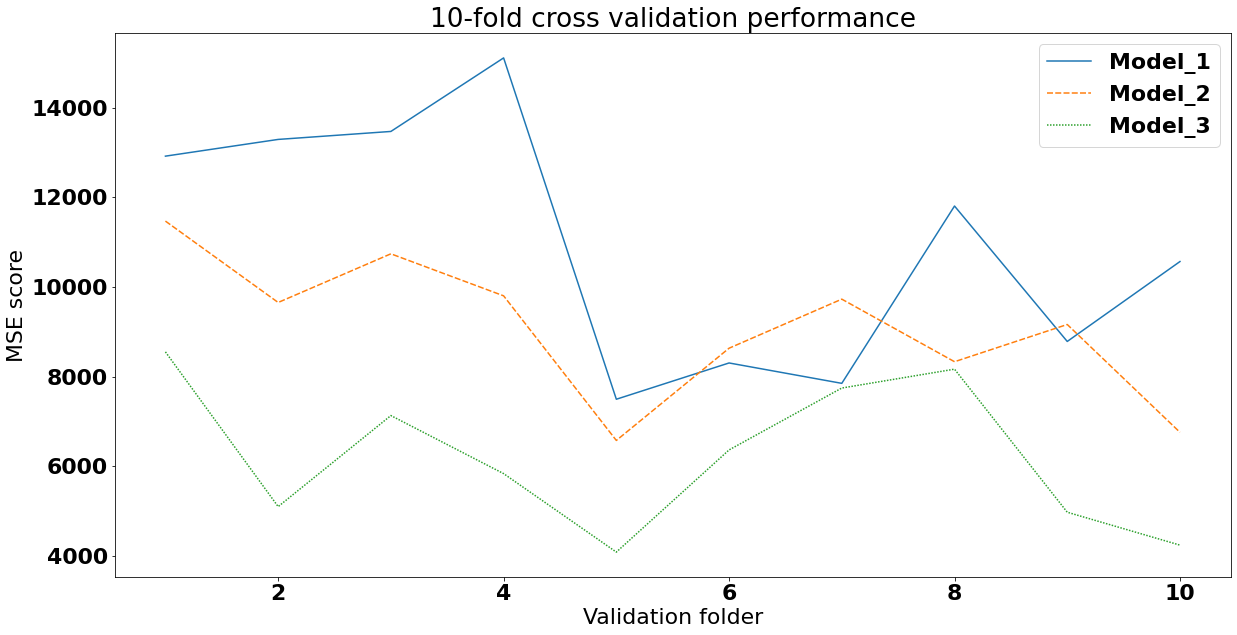

In [ ]:
scores = pd.DataFrame(data=[], columns=["Model_1", "Model_2","Model_3"], index = np.linspace(1,10,10))

scores['Model_1'] = scores_model_1
scores['Model_2'] = scores_model_2
scores['Model_3'] = scores_model_3
plt.figure(figsize=(20,10))
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
plt.rc('font', **font)
sns.lineplot(data=scores)

plt.ylabel("MSE score")
plt.xlabel("Validation folder")
plt.title("10-fold cross validation performance")

After realizing a 10-fold cross validtion on each of our 3 models, we can finally sumarize all MSE scores obtained through each validation folder. 

The first insight we can extract from this graph, is the winning performance of Model 3 (Polynomial regression) on each validation folder.
 
Besides, Our basic model (model 1) shows the poorest performances overall, but can sometimes beat Model 2 (the optimized one) on folders 6, 7, and 9.

Let's now compute some statistics on those evaluation metrics.

### III.C.2 Cheking statistics of each model CV scores

In [ ]:
scores.describe()

,Model_1,Model_2,Model_3
count,10.000000,10.000000,10.000000
mean,10960.887398,9085.778993,6218.002220
std,2732.579729,1570.197028,1628.225050
min,7494.508537,6574.510817,4082.489967
25%,8424.265793,8407.495438,5003.628631
50%,11187.784776,9408.863291,6098.669194
75%,13200.848236,9784.334589,7591.002242
max,15113.732816,11470.968223,8551.786807


The mean CV score of Model 3 is the lowest, confirming the superiority of this model over the others regarding the cross-validation performed. 

Model 2 and Model 1 are quite close, but Model 2 shows better MSE mean score. We can definitely excluse Model 1 from the competition.

However, we can notice **high standard deviation values** regarding the 3 cross-validation scoring vectors. 
This value is at 1628 for Model 3, traducing a quite high variation of the model's predictions, leading to poor generalization on unseen data.

This **maybe due to overfitting** when training the model. We shall keep that in mind when selecting our final candidate. 

To conclude this section, we thus validate Model 2 and Model 3, and will try to choose the best one.



---






<a id='IV'></a>

# IV. Selecting best model and Handling overfitting

So far, we managed to anticipate how well each of our models could generalize on unseen data.
Let's now select our best candidate, and search for optimization.

## IV.A Selecting our best model candidate using the test set 

To select our best candidate, we can evaluate Model 2 and Model 3 on the same independent test set kept idependently during the training and validating process.   


In fact y_test_model3 and y_test_model2 are the same as we split using the same random_split_number.

The only difference between X_test_model2 and X_test _model3 is the number features, where X_test_model3 will have the 2 new polynomial features we created . 

In [ ]:
model2_predictions = model_2.predict(X_test_model2)
model3_predictions  = model_3.predict(X_test_model3)

from sklearn.metrics import mean_absolute_error
print("Test MAE for model 2:",mean_absolute_error(y_test_model2, model2_predictions))
print("Test MAE for model 3:",mean_absolute_error(y_test_model3, model3_predictions))

Test MAE for model 2: 68.88311462096014
Test MAE for model 3: 51.049333638527095


We clearly see the overall superiority of Model 3 over Model 2. Adding polynomial features helped us drop the Mean Absolute Error by 45%.

We thus select Model 3 as our best candidate 

## IV.B Tuning the best candidate with Regularization

### IV.B.1 Showing overfitting on best model

In III.C, we identified a quite important variation in Model 3's cross validation scores. 

Let's plot the validation scores vs the training scores from the 10-fold cross validation we performed on Model 3, to confirm this overfitting pattern :

Text(0.5, 1.0, 'Training vs Validation scores for Model 3')

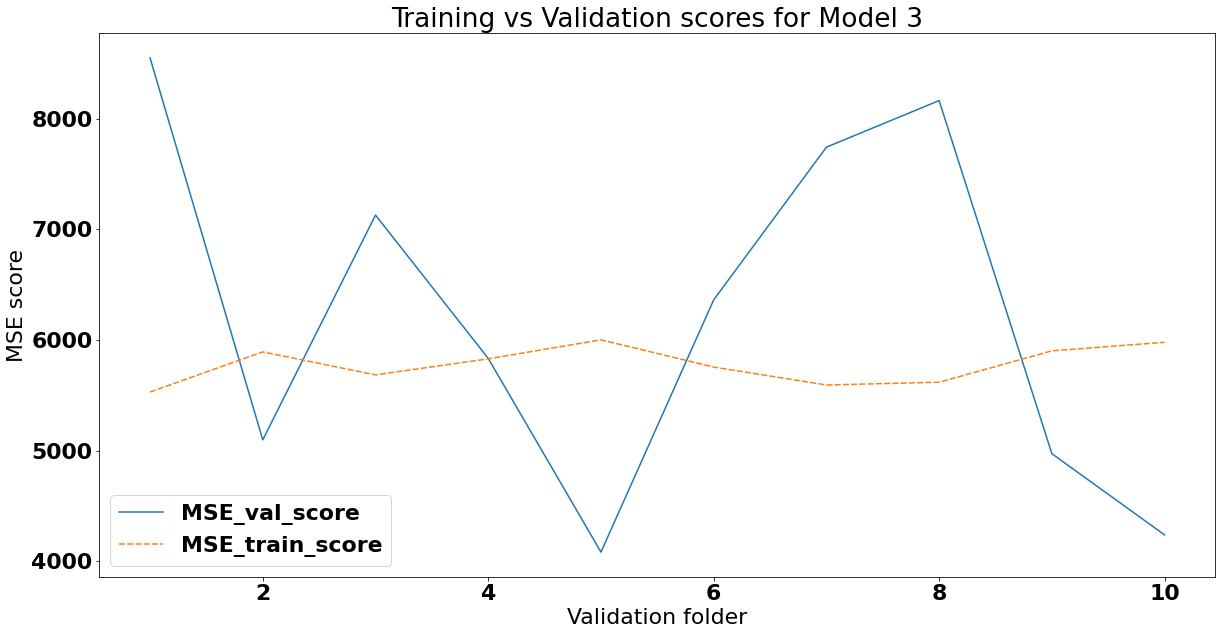

In [ ]:
from sklearn.model_selection import cross_validate
cv_results = cross_validate(LinearRegression(), X_train_model3, y_train_model3, cv=10, scoring="neg_mean_squared_error",return_train_score=True)
model3_scores = pd.DataFrame(data=[], columns=["MSE_val_score", "MSE_train_score"], index = np.linspace(1,10,10))
model3_scores['MSE_val_score'] = abs(cv_results['test_score'])
model3_scores['MSE_train_score'] = abs(cv_results['train_score'])
plt.figure(figsize=(20,10))
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
plt.rc('font', **font)
sns.lineplot(data=model3_scores)

plt.ylabel("MSE score")
plt.xlabel("Validation folder")
plt.title("Training vs Validation scores for Model 3")

We can  strongly see the confrontation between a constant training score vs a highly volatile validation score. 
This strong variation between validation scores and training scores across the is due to overfitting : the model is getting too complex when learning on each training set, causing difficulties to generalize well and a keep a constant score on unseen observations.

In fact, training scores and validation scores are only close to each other on the second validation folder.

To handle this overfitting issue, we can try to decrease the model complexity by adding regularization terms. 

### IV.B.2 Selecting the best regularization technique

In mutlivariate linear regression, regularization can be achieved through :



*   Ridge regression (L2 regularization) in which we penalizes high coefficient estimates by smoothly reducing them down to 0 . It is made possible by adding a factor to our loss function being the MSE :
$$
\mathcal{L}_{Ridge} = \mathcal{L} + \alpha |\theta|^2 
$$
in which  $|\theta|^2$ being the L2 norm of $\theta$:
$$
|\theta|^2 = \sum_j \theta_j^2
$$

and $\theta_j$ being the coefficient estimated for the feature $X_j$

$\alpha$ is called the penalization parameter. This is the hyperparameter we need to tune. 


*   Lasso regression (L1 regularization), which is quite similar to Ridge regression, but instead of adding quadratic values to the cost function, we add the absolute values. The goal is to set some parameters at 0. (the smaller ones): 

$$
\mathcal{L}_{Lasso} = \mathcal{L} + \lambda |\theta|
$$

with $|\theta|$ being the L1 norm of $\theta$:
$$
|\theta| = \sum_j |\theta_j|
$$


*   Elastic-Net regression, in which we add both L1 and L2 regularization :

$$
\mathcal{L}_{ElasticNet} = \mathcal{L} + \alpha_1 |\theta| + \alpha_2 |\theta|^2
$$

We now have two hyperparameters: (only one with scikit-learn)
- $\alpha_1$ for the L1 regularization
- $\alpha_2$ for the L2 regularization






To select the best regularization technique, we can use the GridSearchCV function from scikit-learn, which will perform cross-validation on each alpha value we want to test.

Let's then try each of these techniques and see which one outputs the best mean validation MSE in function of alpha. 

We will search alpha's optimal value among the following values : [0.001, 0.01, 0.1, 1, 10, 100, 1000]

We will first fit the GridSearchCV objects :

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso

# Define the hyperparameter grid we will cross-validate on
param_grid = {
              'alpha': [0.0001, 0.001, 0.1, 1, 10, 100, 1000]}

#Ridge 
grid_Ridge = GridSearchCV(Ridge(),
                    param_grid,
                    scoring='neg_mean_squared_error',
                    cv=10,
                    return_train_score=True
                   )
grid_results_Ridge=grid_Ridge.fit(X_train_model3, y_train_model3)
best_score_Ridge = grid_results_Ridge.best_score_
best_param_Ridge = grid_results_Ridge.best_params_

#Lasso
grid_Lasso = GridSearchCV(Lasso(),
                    param_grid,
                    scoring='neg_mean_squared_error',
                    cv=10,
                    return_train_score=True
                   )
grid_results_Lasso=grid_Lasso.fit(X_train_model3, y_train_model3)
best_score_Lasso = grid_results_Lasso.best_score_
best_param_Lasso = grid_results_Lasso.best_params_

#ElasticNet
grid_Elastic = GridSearchCV(ElasticNet(),
                    param_grid,
                    scoring='neg_mean_squared_error',
                    cv=10,
                    return_train_score=True
                   )
grid_results_Elastic=grid_Elastic.fit(X_train_model3, y_train_model3)
best_score_Elastic = grid_results_Elastic.best_score_
best_param_Elastic = grid_results_Elastic.best_params_

We can then plot the mean validation MSE scores from the 10-fold cross-validation, for each alpha value and for every regularization techniques :

<Figure size 432x288 with 0 Axes>

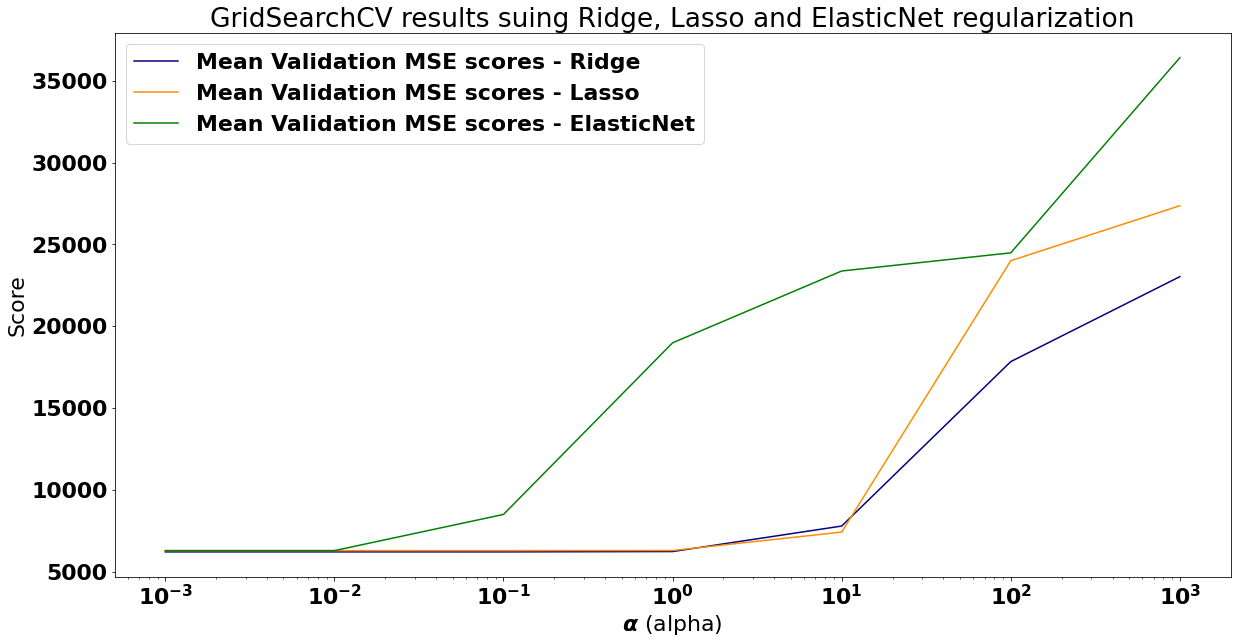

In [ ]:
#plotting synthetized graph of the GridSearchCV results
alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]


validation_scores_mean_Ridge = abs(grid_Ridge.cv_results_["mean_test_score"])
validation_scores_mean_Lasso = abs(grid_Lasso.cv_results_["mean_test_score"])
validation_scores_mean_Elastic = abs(grid_Elastic.cv_results_["mean_test_score"])


plt.figure()
plt.figure(figsize=(20,10))  
plt.title('GridSearchCV results suing Ridge, Lasso and ElasticNet regularization')
plt.xlabel('$\\alpha$ (alpha)')
plt.ylabel('Score')
# plot train scores
plt.semilogx(alphas, validation_scores_mean_Ridge, label='Mean Validation MSE scores - Ridge',
             color='navy')

plt.semilogx(alphas, validation_scores_mean_Lasso,
             label='Mean Validation MSE scores - Lasso', color='darkorange')
plt.semilogx(alphas, validation_scores_mean_Elastic,
             label='Mean Validation MSE scores - ElasticNet', color='green')


font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
plt.rc('font', **font)

             
plt.legend(loc='best')
plt.show()

The graph provides us global view on teh GridSearchCV results we obtanined so far using Ridge, Lasso and ElasticNet regression. 

At first glance, we can directly exclude ElasticNet from the competition : it seems the more we introduce some regularization terms, the worst our mean MSE validation score gets. 

Taking a look at Ridge and Lasso regressions, the competition is looking fierce. However, we can see that the alpha value should not be too high: after alpha=10, the evaluation score is soaring for both techniques. 
Still, for small values of alpha, we may notice the slight decrease in the mean validation MSE : between alpha = 0.001 and alpha = 1, the metric is decreasing, traducing a good usage of regularization.


Let's then output the best alpha value and the mean MSE score reached for this valu, for both Ridge and Lasso :

In [ ]:
# The result of Regularization in nutshell
# initialize a DataFrame to overwrite and fit the data
reg_result = pd.DataFrame(columns = ['Ridge', 'Lasso', 'Elastic'], index = [0.001, 0.01, 0.1, 1, '10', '100', '1000'])
reg_result['Ridge'] = validation_scores_mean_Ridge
reg_result['Lasso'] = validation_scores_mean_Lasso
reg_result['Elastic'] = validation_scores_mean_Elastic
reg_result

,Ridge,Lasso,Elastic
0.001,6218.000997,6294.821700,6294.675805
0.01,6217.990023,6294.817389,6293.865416
0.1,6217.126127,6294.460010,8504.370204
1,6237.915596,6301.831803,18986.132292
10,7794.960568,7427.025798,23373.377252
100,17838.662569,24003.214330,24481.970577
1000,23027.903336,27360.305260,36401.160129


In [ ]:
print("USING LASSO REGRESSION")
print("Best alpha value:", best_param_Lasso)
print("MSE mean score obtained following 10-fold CV with this value:", abs(best_score_Lasso))

print("USING RIDGE REGRESSION")
print("Best alpha value:", best_param_Ridge)
print("MSE mean score obtained following 10-fold CV with this value:", abs(best_score_Ridge))

USING LASSO REGRESSION
Best alpha value: {'alpha': 0.1}
MSE mean score obtained following 10-fold CV with this value: 6294.46000957909
USING RIDGE REGRESSION
Best alpha value: {'alpha': 0.1}
MSE mean score obtained following 10-fold CV with this value: 6217.1261271749445


Both regularization techniques outputs alpha=0.1 as the best optimal value. 
However, the mean MSE reached with alpha=0.1 for Ridge regression is inferior (6217) compared to Lasso regression (6294).

We thus pick the Ridge regression with alpha=0.1 as the regularization we will introduce in the best model we picked so far: model 3. 

### IV.B.3 Showing the effect of regularization in tackling overfitting

Since we manage to select the best regularization technique adapted to our model, let's now see how it can help us reduce the overfitting issue we mentioned in IV.B.1.

To demonstrate this, let's compare the variation of our validation scores we got across the 10-fold cross valdation, between our selected model without regularization and with our selected regularization (Ridge regression). 

In [ ]:
cv_results_with_reg = cross_validate(Ridge(alpha=0.1), X_train_model3, y_train_model3, cv=10, scoring="neg_mean_squared_error",return_train_score=True)
cv_results_without_reg = cross_validate(LinearRegression(), X_train_model3, y_train_model3, cv=10, scoring="neg_mean_squared_error",return_train_score=True)

In [ ]:
print("STD OF MSE VALIDATION SCORES WITHOUT REGULARIZATION",np.std(cv_results_without_reg['test_score']))
print("STD OF MSE VALIDATION SCORES WITH RIDGE REGRESSION",np.std(cv_results_with_reg['test_score']))
print()
print("MEAN OF MSE VALIDATION SCORES WITHOUT REGULARIZATION",abs(np.mean(cv_results_without_reg['test_score'])))
print("MEAN OF MSE VALIDATION SCORES WITH RIDGE REGRESSION",abs(np.mean(cv_results_with_reg['test_score'])))

STD OF MSE VALIDATION SCORES WITHOUT REGULARIZATION 1544.66991027808
STD OF MSE VALIDATION SCORES WITH RIDGE REGRESSION 1541.0162580791116

MEAN OF MSE VALIDATION SCORES WITHOUT REGULARIZATION 6218.002220201695
MEAN OF MSE VALIDATION SCORES WITH RIDGE REGRESSION 6217.1261271749445


We thus managed to slightly decrease our MSE validation score variation using Ridge Regression with alpha =0.1 (1541), as well as improving our mean MSE score (6217). 


However, it is important to recall that overfitting still exist : the variation in our validation scores remains important. This may be due to the poor number of observations we have for training, validating and testing  our model (400 observations so far, so 320 for training and 0.2*320=64 observations for testing each time on a validation folder ! ) 



## IV.C Summing up final model decision 

So far, we : 


*   Selected our best model candidate among the 3 models we have, by picking the one using Polynomial Regression

*   Selected the best regularization technique to tackle the overfitting issue we spot on our best candidate, and improve our evaluation metric, by choosing Ridge regression with alpha =0.1.

Final decision is therefore to **use Model 3, by applying Ridge regression with alpha=0.1**





---





<a id='V'></a>

# V. Model Interpretation

Now it is time to interpret our final selected model, by :

* looking at the different metrics we can compute on our our final independent test set.  
*  visualizing its residuals (or any other viz contents?
*  analyzing mode's output on new observations



##V.A Interpreting Model's metrics

In [ ]:
from sklearn.linear_model import Ridge
#splitting and pre processing
categorical = ["Student"]
numerical = ["Rating", "Age", "Income", "Rating_squared", "Rating_cube"]
X_train_model3, X_test_model3, y_train_model3, y_test_model3  = pre_processing(categorical, numerical, df_cleaned, 0.22)

#training 
model_3 = Ridge(alpha=0.1).fit(X_train_model3, y_train_model3)

#validating 
scores_model_3 = get_cv_scores_mse(model_3,X_train_model3, y_train_model3)

In [ ]:
model_3.get_params()

{'alpha': 0.1,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

In [ ]:
R_squared = model_3.score(X_test_model3,y_test_model3)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
model3_predictions  = model_3.predict(X_test_model3)
MSE=mean_squared_error(y_test_model3, model3_predictions)
RMSE=np.sqrt(mean_squared_error(y_test_model3, model3_predictions))
MAE=mean_absolute_error(y_test_model3, model3_predictions)
error_range=mean_absolute_error(y_test_model3, model3_predictions)/y_test_model3.mean() *100

In [ ]:
model3_summary = pd.DataFrame({'Metric': ['MSE','RMSE','MAE','Rsquared','Error Range %'],
                   'Value': [MSE,RMSE,MAE,R_squared,error_range]
                   },
                  columns = ['Metric', 'Value'])
model3_summary

,Metric,Value
0,MSE,3684.679065
1,RMSE,60.701557
2,MAE,51.133147
3,Rsquared,0.981591
4,Error Range %,8.692098



*   The set of features ("Student", "Rating", "Age", "Income", "Rating_squared", "Rating_cube") is able to explain 98% of the variability of AvgDebt
*   On average, the predicted AvgDebt can be 51 units away from the true value (e.g if true value of AvgDebt = 200, predicted AvgDebt can be 200-51=149 or 200+51=251), with an error range of 8.69%  



In [ ]:
model3_coef = pd.DataFrame({'Coefficients': list(X_train_model3),
                   'Value': model_3.coef_
                   },
                  columns = ['Coefficients', 'Value']
                  )
model3_coef.set_index('Coefficients',inplace=True)
model3_coef.loc["Intercept"]=model_3.intercept_
model3_coef

,Value
Coefficients,
Student_Yes,434.278795
Rating,-2.139026
Age,-0.917711
Income,-8.970382
Rating_squared,0.014832
Rating_cube,-0.000010
Intercept,225.512907


From the coefficients of the model, we conclude the marginal effect of each variable, while keeping all other regressors constant:

1. Being a student increases the Average Debt by 434.27 Euros
2. Increasing the Rating by 1 unit decreases the Average Debt by 2.139 Euros
3. Increasing Age by 1 unit decreases the Average Debt by 0.917 Euro
4. Increasing Income by 1 unit decreases the Average Debt by 8.97 Euros



$\mathbf{\hat{AvgDebt}}= 434.27*\mathbf{Student} -2.139*\mathbf{Rating} -0.917*\mathbf{Age} -8.97*\mathbf{Income} + 0.014*\mathbf{Rating^{2}} -0.00001*\mathbf{Rating^{3}} + 0.1\boldsymbol{|\theta|} + 225.51$

## V.B Visualizing Model Prediction and Residuals

In [ ]:
# improvising a DataFrame of test set result
test_and_pred = pd.DataFrame(columns = ['x','test', 'predict'], index = np.arange(0,81,1))
test_and_pred['x'] = np.arange(0,81,1)
test_and_pred['test'] = y_test_model3.array
test_and_pred['predict'] = model3_predictions

<Figure size 432x288 with 0 Axes>

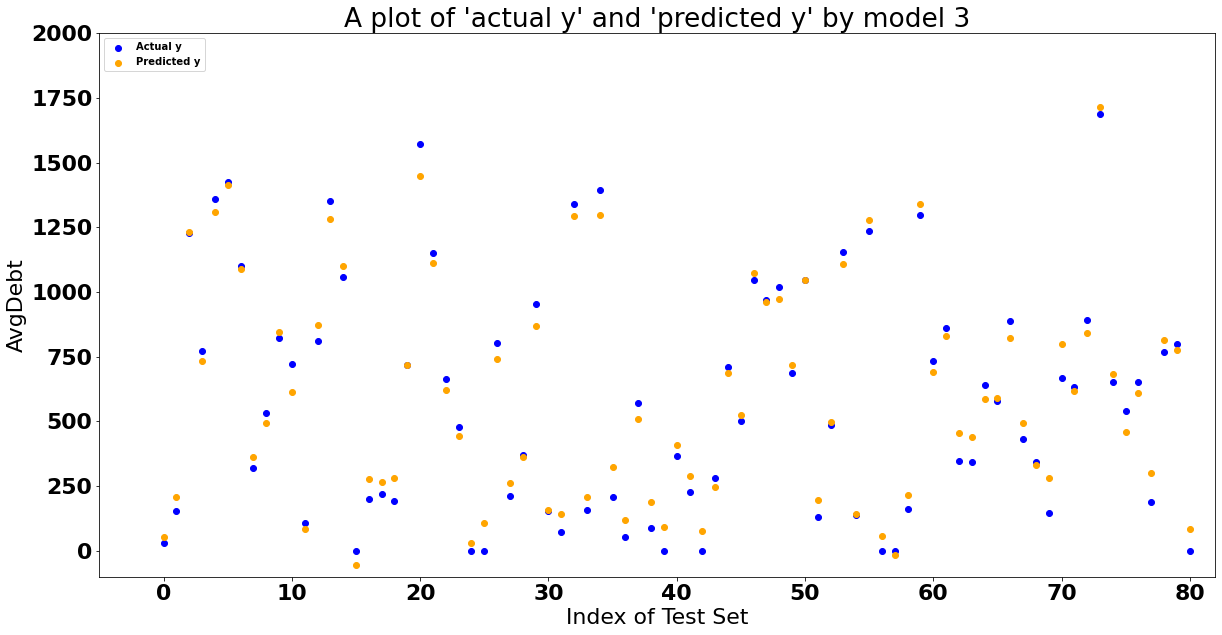

In [ ]:
# a plot of actual y and predicted y in glance
plt.figure()
plt.figure(figsize=(20,10))  
plt.xlabel('Index of Test Set')
plt.ylabel('AvgDebt')
plt.title("A plot of 'actual y' and 'predicted y' by model 3")

plt.scatter(test_and_pred['x'],test_and_pred['test'], color = 'blue')
plt.scatter(test_and_pred['x'],test_and_pred['predict'], color = 'orange')


plt.xlim (-5,82)
plt.ylim(-100, 2000)
colors = ['blue', 'orange']
labels = ['blue dot', 'oragne dot']
plt.legend(['Actual y', 'Predicted y'], loc = 'upper left', ncol = 1, fontsize = 10, frameon = True)

The test visually seems not over-estimated or underestimated the explanatory variable 'AvgDebt' according to the model3. 

Let's dive deeper to see whether or not any meaningful residual is left.

[Text(0, 0.5, 'Residuals'),
 Text(0.5, 0, "Predicted 'AvgDebt'"),
 Text(0.5, 1.0, 'Residual Plot of Model 3')]

<Figure size 432x288 with 0 Axes>

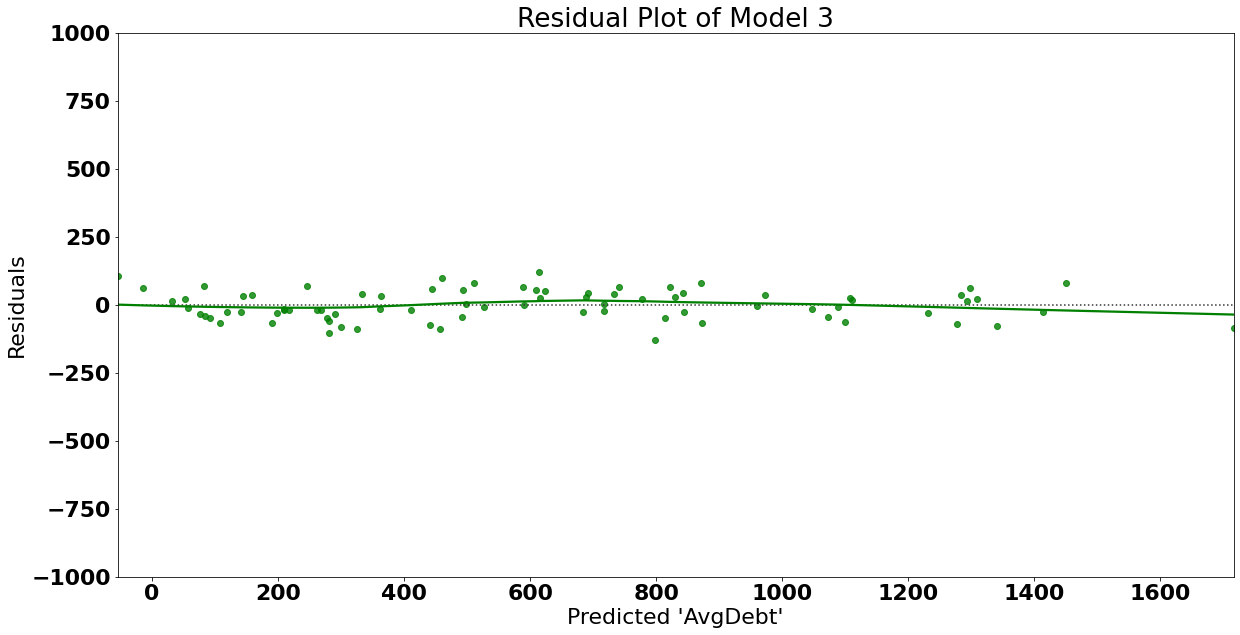

In [ ]:
# residual plot

rs = (y_test_model3-model3_predictions).array
x = test_and_pred['predict']
plt.figure()
plt.figure(figsize=(20,10))  
plt.ylim(-1000,1000)

sns.residplot(x= x, y = rs, lowess=True, color="g").set(title = "Residual Plot of Model 3", ylabel = "Residuals", xlabel = "Predicted 'AvgDebt'")



In the residual plot above, the slope of regression line is 0, which visully means there's no correlation left in the residual set.

The residual plots satisfy **the homoscedasticity of our regression model** which means the variance of each predictors are equally scattered without a pattern.

[Text(0, 0.5, 'Frequency'),
 Text(0.5, 0, 'Residuals of Test Set'),
 Text(0.5, 1.0, 'Histrogram of Residuals on test set')]

<Figure size 432x288 with 0 Axes>

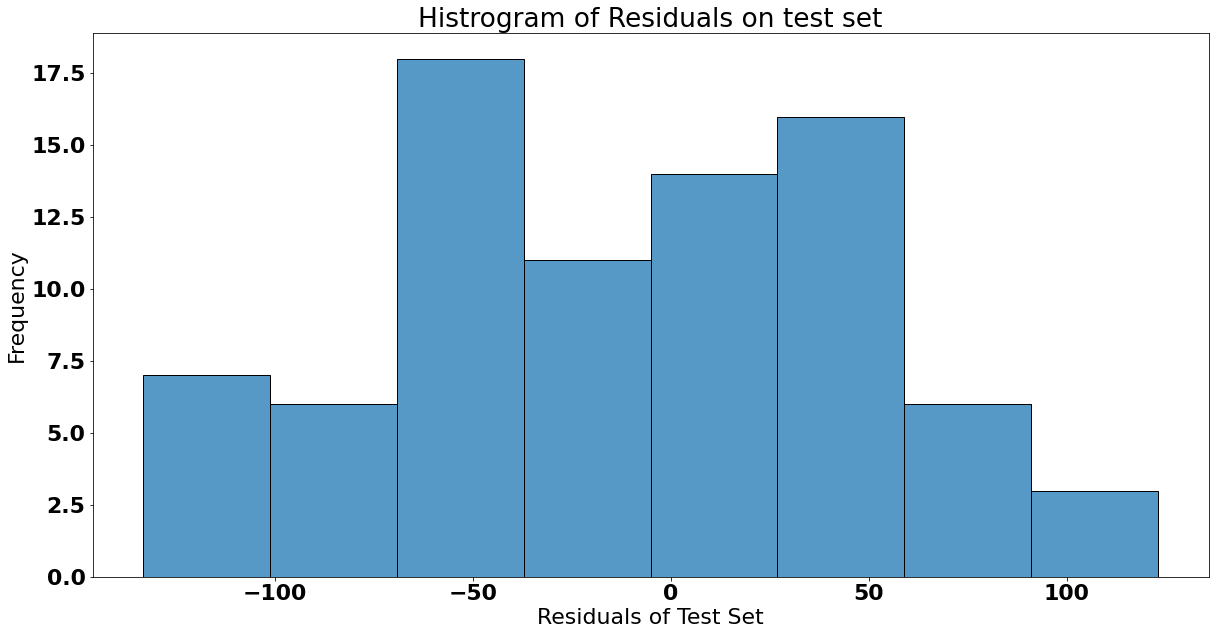

In [ ]:
plt.figure()
plt.figure(figsize=(20,10))  
sns.histplot(rs).set(title = "Histrogram of Residuals on test set", xlabel = "Residuals of Test Set", ylabel = "Frequency")

The above histogram of the residuals can be used to check whether or not the variance is normally distributed. 

A symmetric bell shape that is evenly distributed around zero strongly proves that the normality assumption is likely to be true.

## V.C Testing and analysing model's output new observations

We would like to test our model to a new customer set. Our project sponsor in financial sector wants to prototype this model to evaluate potential customers who are going to leverage their finance in near future. The 4 virtual samples which represent the typcial segments of customers in bank with presumptions below;
-  student: Those who are the youngest with low level of income and rating.
- professional: Those who have the highest income flow and rating.
- unemployeed: Those who have a low level of income and rating, and meidan age.
- retired: The who are the oldest and have moderate income flow and rating.

In [ ]:
# a virtual customer table to test the model in a new customer set
virtual_customer  = pd.DataFrame(columns = ['Student_Yes', 'Rating', 'Age', 'Income', 'Rating_squared', 'Rating_cube'], index = ['student', 'professional', 'unemployed', 'retired'])
virtual_customer.loc['student'] = [1, 289, 25, 21, 289**2, 289**3 ]
virtual_customer.loc['professional'] = [0,450, 35, 70, 450**2, 450**3]
virtual_customer.loc['unemployed'] = [0, 200, 40, 30, 200**2, 200**3]
virtual_customer.loc['retired'] = [0, 350, 65, 50, 350**2, 350**3]
virtual_customer

,Student_Yes,Rating,Age,Income,Rating_squared,Rating_cube
student,1,289,25,21,83521,24137569
professional,0,450,35,70,202500,91125000
unemployed,0,200,40,30,40000,8000000
retired,0,350,65,50,122500,42875000


In [ ]:
# predict AvgDebt based on our final model
print('The expected Average Debt of potential customer set "student", "professional", "unemployed", "retired" are as followed is as followed: {}'.format(model_3.predict(virtual_customer)))

The expected Average Debt of potential customer set "student", "professional", "unemployed", "retired" are as followed is as followed: [818.96785146 662.11907561   2.27897703 341.33126648]


In [ ]:
# virtual_customer DataFrame with the result in descending order
virtual_customer['AvgDbt'] = model_3.predict(virtual_customer)
virtual_customer.sort_values(by = ['AvgDbt'], ascending = False)

,Student_Yes,Rating,Age,Income,Rating_squared,Rating_cube,AvgDbt
student,1,289,25,21,83521,24137569,818.967851
professional,0,450,35,70,202500,91125000,662.119076
retired,0,350,65,50,122500,42875000,341.331266
unemployed,0,200,40,30,40000,8000000,2.278977


According to our AvgDebt prediction model, **student and professionals** are the most profitable segments to sell loan products.

Those who are unemployed could be the least profitable segment due to their lowest rating, which is a predictor variable with a huge wieght in the model.



---





# Conclusion

From data exploration until final intepreation, we manage to deliver an accurate model predicting the individual's credit card debt. 

By selecting significant features, adding polynomial variables and tuning our best model candidate with regularization, we kept reducing the amount of error in our predictions. 

However, even though we presented a way to handle an  overfitting issue, one should keep in mind that this probelm remains. 

For further improvements, we could have tried other modelling techniques, using ensemble learning methods such as bagging with Random forests or boosting with XGBoost, but the purpose of the project was to stay in the linear regression's framework, showing its advantages but also its limits. 

Thank you !

                                                                 Charles, Omar and Hojun
                                                                 EDHEC, MSc DAAI 2020-2201